# **United States Coal Mines and Classification**

![Alt text](Images/Coal_Seam_at_Coal_Mine.png)

 An 80 foot coal seam at the North Antelope Rochelle opencut coal mine.

By Peabody Energy, Inc. - Provided by Peabody Energy, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=36846291

## **Objective**

The objective of this project is to analyze coal data provided by [U.S. Energy Information Administration](https://www.eia.gov/), build and deploy machine learning models that can classify coal based on parameters like heat_content, ash_content and sulphur_content.

## **Contents**

- **Introduction**
    - What is coal?
    - How is coal formed?
    - Types of coal
- **Data Pipeline**
- **Data Gathering**
- **Loading Mines Data**
- **Geospatial Analysis of US Coal Mines**
- **Loading Coal Data**
- **Exploratory Data Analysis**
- **How has the coal production changed since 2001?**
- **Split the Data into Train and Test Sets**
- **Handling Outliers**
- **Handling Imbalance in the data**
- **Correlation and Statistical Test**
    - Analysis of Variance for Ash-Content
    - Analysis of Variance for Sulfur-Content
    - Analysis of Variance for Heat-Content
- **Detecting Multicollinearity**
- **Summarize and Plan the Transformation Pipeline**
- **Transformation Pipeline**
- **Machine Learning**
    - Softmax Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Feed Forward Network 
- **Hyperparameter Tuning**
- **Saving Best Models**
- **Predicting on the Test Set**

## **Introduction**

#### What is coal?
Coal is a combustible black or brownish-black sedimentary rock, formed as rock strata called *coal seams*. Coal is mostly carbon with variable amounts of other elements, chiefly hydrogen, sulfur, oxygen and nitrogen. Coal is classified as non-renewable energy source because it takes millions of years to form. Coal contains energy stores by plants that lived hundreds of millions of years ago in swampy forests.

#### How is coal formed?
Coal is formed when dead plant matter decays into *peat* and is converted into coal by the heat and pressure of deep burial over millions of years. Vast deposits of coal originate in former wetlands called *coal forests* that covered much of the Earth's tropical land areas during the Carboniferous and Permian times. Many significant coal deposits are younger than this and originate from the Mesozoic and Cenozoic eras.

#### Types of coal

Coal is classified into four main types, or ranks: Anthracite, Bituminous, Subbituminous and Lignite. The ranking depends on the types and amounts of carbon the coal contains and on the amount of heat energy the coal can produce. The rank of a coal deposit is determined by the amount of pressure and the heat that acted on the plants over time.

**Anthracite**, also known as **hard coal**, and **black coal**, is a hard, compact variety of coal that has a submetallic luster. It has the highest carbon content, the fewest impurities, and the highest energy density of all types of coal and is the highest ranking of coals. It is the most metamorphosed type of coal (but still represents a low-grade metamorphism) in which the carbon content is between 86% and 97%. Anthracite ignites with difficulty and burns with a short, blue, and smokeless flame.<br>
Anthracite is categorized into standard grade, which is used mainly in power generation, high grade (HG) and ultra high grade (UHG), the principal uses of which are in the metallurgy sector. Anthracite accounts for about 1% of global coal reserves, and is mined in only a few countries around the world. 

**Bituminous** coal is a particular rank of coal, as determined by the amount and type of carbon present in the coal and the amount of energy it can produce when burned. It is higher in rank than sub-bituminous coal but lower in rank than anthracite. Bituminous coal is the most abundant rank of coal. Bituminous coal is dark brown to black, hard, but friable. It is commonly composed of thin bands of alternating bright and dull material.

**Subbituminous** coal is a lower grade of coal that contains 35–45% carbon. The properties of this type are between those of lignite, the lowest grade of coal, and those of bituminous coal, the second-highest grade of coal. Sub-bituminous coal is primarily used as a fuel for steam-electric power generation. Sub-bituminous coals may be dull, dark brown to black, soft and crumbly at the lower end of the range, to bright jet-black, hard, and relatively strong at the upper end.

**Lignite** often referred to as brown coal, is a soft, brown, combustible, sedimentary rock formed from naturally compressed peat. It has a carbon content around 25–35%, and is considered the lowest rank of coal due to its relatively low heat content. When removed from the ground, it contains a very high amount of moisture which partially explains its low carbon content. Lignite is mined all around the world and is used almost exclusively as a fuel for steam-electric power generation.

## **Data Pipeline**

![Alt text](Flowcharts/US%20Coal%20Mines%20and%20Classification%20Data%20Pipeline.drawio.png)

Flowchart Tool: https://app.diagrams.net/

## **Data Gathering**

In [1]:
# Import libraries to fetch data using API
import requests
import numpy as np
np.set_printoptions(precision=2, floatmode='fixed')
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
# import matplotlib_inline.backend_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

EIA's API only returns a maximum of 5000 rows per call, even if more data points are responsive to your
request. However, at the time of writing this notebook there were 30428 data points for the below API route and parameters. I will use 'for loop' to make multiple API calls and gather all the data points.

Please refer EIA's [API Technical Documentation](https://www.eia.gov/opendata/documentation.php)
for details.

#### US Coal Data

In [ ]:
# Make 'get' request
# ----------------------

API_KEY = "0lYC7bqbDeJlaGEq9FtDInoeE9a8ldMvLVPRId1S"
END_POINT = f"https://api.eia.gov/v2/coal/shipments/plant-aggregates/data/?api_key={API_KEY}"

offsets = [0, 5000, 10000, 15000, 20000, 25000, 30000]
list_of_responses = []

for i in range(7): # Excuse me for the hard coded range function. Recommended: `for i in range(len(offsets))`
    
    payload = {
    "frequency": "quarterly",
    "data[0]": "ash-content",
    "data[1]": "heat-content",
    "data[2]": "price",
    "data[3]": "quantity",
    "data[4]": "sulfur-content",
    "facets[rank][0]": "ANT",
    "facets[rank][1]": "BIT",
    "facets[rank][2]": "LIG",
    "facets[rank][3]": "SUB",
    "start": "2008-Q1",
    "end": "2021-Q1",
    "sort[0][column]": 'period',
    "sort[0][direction]": 'desc',
    "offset": f'{offsets[i]}',
    "length": '5000',
    }

    response = requests.get(url=END_POINT, params=payload)
    coal_data = response.json()
    list_of_responses.append(coal_data)
print(list_of_responses)

In [ ]:
# Parse the json data
# -------------------

# Create a DataFrame
column_names = [
    'period', 'location', 'plantStateDescription', 'plant', 'plantName','rank',
    'coalRankDescription', 'ash-content', 'heat-content', 'price', 'quantity', 
    'sulfur-content','ash-content-units', 'heat-content-units', 'price-units', 
    'quantity-units', 'sulfur-content-units'
]

data_original = pd.DataFrame(columns=column_names)

# 'list_of_responses' is a list containing all 7 repsonses we got from EIA, each element in
# the list is a dictionary with multiple 'key: value' pairs. We will store values corresponding
# to 'data' keys of all responses in a new list called 'list_of_response_data'.

list_of_response_data = []
for resp in list_of_responses:
    response_data = resp['response']['data']
    list_of_response_data.append(response_data)
    
# 'list_of_response_data' now is a nested list. We can flatten this nested list using sum() function.

response_data_flattened = sum(list_of_response_data, [])

# Fill the Dataframe

for index, dic in enumerate(response_data_flattened):
    data_original.loc[index] = [
        dic['period'], dic['location'], dic['plantStateDescription'], dic['plant'], 
        dic['plantName'], dic['rank'], dic['coalRankDescription'], dic['ash-content'],
        dic['heat-content'], dic['price'], dic['quantity'], dic['sulfur-content'],
        dic['ash-content-units'], dic['heat-content-units'], dic['price-units'], 
        dic['quantity-units'], dic['sulfur-content-units']
        ]
data_original

In [14]:
units_list = ['ash-content-units', 'heat-content-units', 'price-units', 'quantity-units', 'sulfur-content-units']

for unit in units_list:
    print(data_original[unit].unique())

['percent by weight']
['Btu per pound']
['average dollars per ton']
['tons']
['percent by weight']


There are no discrepancies in the units used to measure features. We can now delete all columns pertaining to units.

In [ ]:
data = data_original.drop(units_list, axis=1)
data.head()

In [16]:
# Save data as .csv
data.to_csv("datasets/US_coal_data.csv", index=False)

#### US Mines Data

Coal mines coordinate data is not accessible via the above route, we need to access it with a different route as shown below.

In [ ]:
# Make 'get' request for mines data
# -------------------------------------

API_KEY = '0lYC7bqbDeJlaGEq9FtDInoeE9a8ldMvLVPRId1S'
MINES_END_POINT = f'https://api.eia.gov/v2/coal/mine-production/data/?api_key={API_KEY}'

years = np.arange(2001,2022,1).tolist()
# years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
#        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
#        2017, 2018, 2019, 2020, 2021]

mines_response_list = []

for i in range(len(years)):
    mines_payload = {
        'frequency': 'annual',
        'data[0]': 'latitude',
        'data[1]': 'longitude',
        'data[2]': 'operating-company',
        'data[3]': 'operating-company-address',
        'data[4]': 'production',
        'start': f'{years[i]}',
        'end': f'{years[i]}',
        'sort[0][column]': 'period',
        'sort[0][direction]': 'desc',
        'offset': '0',
        'length': '5000'
        }

    mines_response = requests.get(url=MINES_END_POINT, params=mines_payload)
    mines_data = mines_response.json()
    mines_response_list.append(mines_data)

In [ ]:
print(mines_data['response']['data'][0])

In [ ]:
# Parse the mines json data
# -------------------------

# Create a DataFrame
mines_column_names = [
    'period', 'mineMSHAId', 'mineName', 'stateId', 'stateDescription','regionId',
    'regionDescription', 'supplyRegionId', 'supplyRegionDescription', 'censusRegionId', 'censusRegionDescription', 
    'mississippiRegionId','mississippiRegionDescription', 'mineCountyId', 'mineCountyName', 
    'coalRankId', 'coalRankDescription', 'mineTypeId', 'mineTypeDescription', 'mineStatusId',
    'mineStatusDescription', 'latitude', 'longitude','operating-company', 
    'operating-company-address', 'production', 'production-units'  
]

mines_data_original = pd.DataFrame(columns=mines_column_names)

# 'mines_response_list' is a list containing all 21 repsonses we got from EIA, each element in
# the list is a dictionary with multiple 'key: value' pairs. We will store values corresponding
# to 'data' keys of all responses in a new list called 'mines_list_of_response_data'.

mines_list_of_response_data = []
for resp in mines_response_list:
    mines_response_data = resp['response']['data']
    mines_list_of_response_data.append(mines_response_data)
    
# 'mines_list_of_response_data' now is a nested list. We can flatten this nested list using sum() function.

mines_response_data_flattened = sum(mines_list_of_response_data, [])

# Fill the Dataframe

for index, dic in enumerate(mines_response_data_flattened):
    mines_data_original.loc[index] = [
        dic['period'], dic['mineMSHAId'], dic['mineName'], dic['stateId'], dic['stateDescription'], dic['regionId'],
        dic['regionDescription'], dic['supplyRegionId'], dic['supplyRegionDescription'], dic['censusRegionId'], dic['censusRegionDescription'], 
        dic['mississippiRegionId'], dic['mississippiRegionDescription'], dic['mineCountyId'], dic['mineCountyName'], 
        dic['coalRankId'], dic['coalRankDescription'], dic['mineTypeId'], dic['mineTypeDescription'], dic['mineStatusId'],
        dic['mineStatusDescription'], dic['latitude'], dic['longitude'], dic['operating-company'], 
        dic['operating-company-address'], dic['production'], dic['production-units']
        ]
mines_data_original

In [ ]:
mines_data_original['production-units'].unique()

In [ ]:
mines_data_original.to_csv('datasets/EIA/US_coal_mines(year-wise).csv')

## **Loading Mines Data**

In [2]:
US_coal_mines_org = pd.read_csv('datasets/EIA/US_coal_mines(year-wise).csv')

In [3]:
US_coal_mines_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34714 entries, 0 to 34713
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   period                        34714 non-null  int64  
 1   mineMSHAId                    34714 non-null  int64  
 2   mineName                      34714 non-null  object 
 3   stateId                       34714 non-null  object 
 4   stateDescription              34714 non-null  object 
 5   regionId                      34714 non-null  object 
 6   regionDescription             34714 non-null  object 
 7   supplyRegionId                34714 non-null  object 
 8   supplyRegionDescription       34714 non-null  object 
 9   censusRegionId                34714 non-null  object 
 10  censusRegionDescription       34714 non-null  object 
 11  mississippiRegionId           34714 non-null  object 
 12  mississippiRegionDescription  34714 non-null  object 
 13  m

In [4]:
US_coal_mines_org.isnull().sum() # Number of missing values in each variable.

period                             0
mineMSHAId                         0
mineName                           0
stateId                            0
stateDescription                   0
regionId                           0
regionDescription                  0
supplyRegionId                     0
supplyRegionDescription            0
censusRegionId                     0
censusRegionDescription            0
mississippiRegionId                0
mississippiRegionDescription       0
mineCountyId                       0
mineCountyName                     0
coalRankId                         0
coalRankDescription                0
mineTypeId                         0
mineTypeDescription                0
mineStatusId                       0
mineStatusDescription              0
latitude                        6521
longitude                       6521
operating-company                  0
operating-company-address          0
production                         0
production-units                   0
d

In [5]:
# Let's implement 'Complete Case Analysis'
US_coal_mines = US_coal_mines_org.dropna()

## **Geospatial Analysis of US Coal Mines**

Geospatial Analysis will be made using 'GeoPandas'. GeoPandas is not a built-in python library, so please refer the [official documentation](https://geopandas.org/en/stable/) for installation and usage. After installing the library, if you face any errors with its dependencies, this [link](https://geoffboeing.com/2014/09/using-geopandas-windows/) may help.

**Additional file required:**<br>

US 'Shapefile' can be found [here](https://www.diva-gis.org/gdata). 
- Select 'United States'
- Subject: 'Administrative areas'

In [6]:
import folium

In [7]:
# Load the shape file
shapefile_path = 'datasets/test_datasets/USA_adm1.shp'
USA = gpd.read_file(shapefile_path)
USA.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,244,USA,United States,1,Alabama,State,State,None,AL|Ala.,"MULTIPOLYGON (((-88.11320 30.22623, -88.11291 ..."
1,244,USA,United States,2,Alaska,State,State,None,AK|Alaska,"MULTIPOLYGON (((-179.13147 51.20972, -179.1322..."
2,244,USA,United States,2,Alaska,State,State,None,AK|Alaska,"MULTIPOLYGON (((-141.31459 60.05416, -141.3125..."
3,244,USA,United States,3,Arizona,State,State,None,AZ|Ariz.,"POLYGON ((-110.53930 37.00423, -110.47991 37.0..."
4,244,USA,United States,4,Arkansas,State,State,None,AR|Ark.,"POLYGON ((-93.36903 36.49686, -93.36530 36.496..."


In [8]:
USA = USA.drop(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1'], axis=1)

In [9]:
USCM_unq = US_coal_mines.copy()
USCM_unq = USCM_unq.drop_duplicates(subset=['mineName'], keep='first')
USCM_unq = USCM_unq.drop([
    'mineMSHAId',
    'stateId',
    'regionId',
    'regionDescription',
    'supplyRegionId',
    'supplyRegionDescription',
    'censusRegionId',
    'censusRegionDescription',
    'mississippiRegionId',
    'mississippiRegionDescription',
    'mineCountyId',
    'mineCountyName',
    'coalRankId',
    'mineTypeId',
    'mineStatusId',
], axis=1
)

In [10]:
# Create a GeoDataFrame object containing Coal Mines Data. (USCM -> US Coal Mines)
USCM_geo = gpd.GeoDataFrame(
    data=USCM_unq,
    geometry=gpd.points_from_xy(USCM_unq['longitude'], USCM_unq['latitude'])
)

In [ ]:
# Plot
USA_map = USA.explore(
    tooltip='NAME_1',
    popup=True,
    name='USA'
)

USCM_geo.explore(
    m=USA_map,
    color='red',
    marker_kwds=dict(radius=7, fill=True),
    popup=True,
    tooltip='mineName',
    name='US Coal Mines'
)

folium.TileLayer('CartoDB dark_matter', control=True).add_to(USA_map)
folium.LayerControl().add_to(USA_map)

USA_map

## **Loading Coal Data**

In [6]:
US_coal_data = pd.read_csv("datasets/US_coal_data.csv")

In [7]:
coal = US_coal_data.copy()
coal.head()

,period,location,plantStateDescription,plant,plantName,rank,coalRankDescription,ash-content,heat-content,price,quantity,sulfur-content
0,2021-Q1,IN,Indiana,6113,Gibson,BIT,Bituminous,9.23,11337,48.95,618268,2.80
1,2021-Q1,WY,Wyoming,6101,Wyodak,SUB,Subbituminous,5.88,8103,19.26,324988,0.51
2,2021-Q1,WVS,West Virginia (Southern),10043,Logan Generating Plant,BIT,Bituminous,6.85,12901,w,55840,1.48
3,2021-Q1,IN,Indiana,8837,Calvert City,BIT,Bituminous,8.20,11984,42.97,354472,2.52
4,2021-Q1,WY,Wyoming,8219,Ray D Nixon,SUB,Subbituminous,4.16,8800,28.02,197024,0.19


In [8]:
coal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30428 entries, 0 to 30427
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   period                 30428 non-null  object 
 1   location               30428 non-null  object 
 2   plantStateDescription  30428 non-null  object 
 3   plant                  30428 non-null  int64  
 4   plantName              30428 non-null  object 
 5   rank                   30428 non-null  object 
 6   coalRankDescription    30428 non-null  object 
 7   ash-content            30428 non-null  float64
 8   heat-content           30428 non-null  int64  
 9   price                  30428 non-null  object 
 10  quantity               30428 non-null  int64  
 11  sulfur-content         30428 non-null  float64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.8+ MB


Although the above chart shows that there are no missing values, the dtype of price is 'object' which is misleading. Let's inspect and fix this column. 

In [9]:
coal['price'].nunique() # Number of unique elements

6927

In [10]:
def is_numeric(string: str) -> str:
    """Takes a string and returns it if non-numeric.

            Argument:
                    string (str): A string
            Returns:
                    string (str): The same string
    
    """
    try:
        float(string)
        pass
    except ValueError:
        return string

In [11]:
non_numeric_list = []
for price in coal['price']:
    non_numeric_value = is_numeric(price)
    if not non_numeric_value == None:
        non_numeric_list.append(non_numeric_value)

print(f"Unique misleading/missing values: {set(non_numeric_list)}")
print(f"Number of misleading/missing values in 'price' column: {len(non_numeric_list)}")
print(f"Percentage of missleading/missing values {round(len(non_numeric_list)/len(coal['price'])*100, 2)}%")

# The above code checks if values in price column are non_numeric or not. If non_numeric 
# it stores in 'non_numeric_list' and then prints relevant information. 

Unique misleading/missing values: {'w'}
Number of misleading/missing values in 'price' column: 7782
Percentage of missleading/missing values 25.58%


We shall keep the variable, perhaps impute it with mean or median of the column. But first we need to convert it to float. Let's replace the 'w's with `np.nan`.

In [12]:
coal['price'] = coal['price'].replace('w', np.nan) # Replace all 'w' with nan values.
coal['price'] = coal['price'].astype(float) # Convert the 'price' column to float.
coal['price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 30428 entries, 0 to 30427
Series name: price
Non-Null Count  Dtype  
--------------  -----  
22646 non-null  float64
dtypes: float64(1)
memory usage: 237.8 KB


Now that the datatype of `coal['price']` is handled, let's visualize the data points. 

## **Exploratory Data Analysis**

In [13]:
coal_eda = coal.copy()

In [14]:
coal_eda['rank'].unique()

array(['BIT', 'SUB', 'LIG', 'ANT'], dtype=object)

In [15]:
category_frequency = coal_eda['rank'].value_counts()
category_frequency # Total number of entries per category including null values.

BIT    20261
SUB     9212
LIG      938
ANT       17
Name: rank, dtype: int64

In [16]:
# Let's group the prices based on rank
prices_by_rank = coal_eda.pivot(columns='rank', values='price')
prices_by_rank.head()

rank,ANT,BIT,LIG,SUB
0,NaN,48.95,NaN,NaN
1,NaN,NaN,NaN,19.26
2,NaN,NaN,NaN,NaN
3,NaN,42.97,NaN,NaN
4,NaN,NaN,NaN,28.02


In [17]:
prices_by_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30428 entries, 0 to 30427
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ANT     7 non-null      float64
 1   BIT     14891 non-null  float64
 2   LIG     583 non-null    float64
 3   SUB     7165 non-null   float64
dtypes: float64(4)
memory usage: 1.2 MB


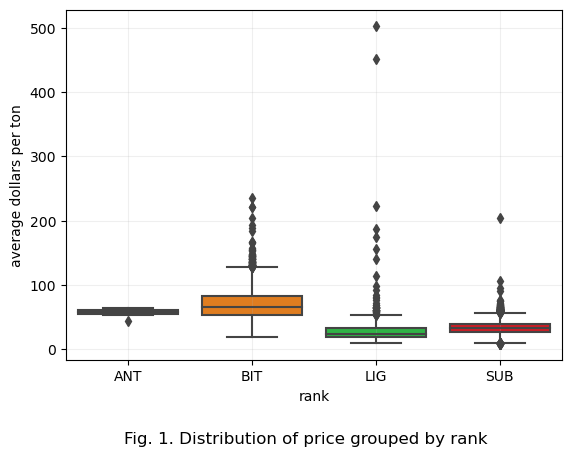

In [18]:
# Visualizing distribution of price with boxplots
sns.boxplot(data=prices_by_rank, palette='bright')
plt.grid(alpha=0.2)
plt.ylabel('average dollars per ton')
plt.suptitle('Fig. 1. Distribution of price grouped by rank', y=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

#### Identifying Outliers in Price

Let's identifying outliers using inter-quartile range (IQR) proximity rule.
According to IQR 1.5 proximity rule a value is an outlier if it falls outside of these boundaries:

$Upper\:boundary = 75^{th} quantile + (IQR * 1.5)$<br>
$Lower\:boundary = 25^{th} quantile - (IQR * 1.5)$<br>
$IQR = 75^{th} quantile - 25^{th} quantile$

In [19]:
def boundaries(data, feature: str, distance: float) -> tuple:
    """ 
    Calculates boundaries in accordance with IQR proximity rule.

        Arguments:
                data: A DataFrame

                feature: (str), column name in the Dataframe

                distance: (float), A non_negative number

        Returns:
                boundaries (Tuple): Upper_boundary, Lower_boundary 
    """
    IQR = data[feature].quantile(0.75) - data[feature].quantile(0.25)

    upper_boundary = data[feature].quantile(0.75) + (IQR * distance)
    lower_boundary = data[feature].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [20]:
# Create a Dataframe to store boundary values for different ranks of coal.
boundaries_df = pd.DataFrame(columns=['Rank', 'Upper boundary', 'Lower boundary'])
for index, column_name in enumerate(prices_by_rank.columns):
    upper_boundary, lower_boundary = boundaries(prices_by_rank, column_name, 1.5)
    boundaries_df.loc[index] = column_name, upper_boundary, lower_boundary
boundaries_df.set_index('Rank', inplace=True)
boundaries_df

,Upper boundary,Lower boundary
Rank,,
ANT,72.5375,44.1975
BIT,128.0500,7.5300
LIG,53.2750,-2.0850
SUB,56.7550,9.9150


In [21]:
ant_price_outliers = np.where(
    prices_by_rank['ANT'] > boundaries_df.loc['ANT', 'Upper boundary'], 
    True, 
    np.where(prices_by_rank['ANT'] < boundaries_df.loc['ANT', 'Lower boundary'], True, False)
    )

bit_price_outliers = np.where(
    prices_by_rank['BIT'] > boundaries_df.loc['BIT', 'Upper boundary'], 
    True, 
    np.where(prices_by_rank['BIT'] < boundaries_df.loc['BIT', 'Lower boundary'], True, False)
    )

lig_price_outliers = np.where(
    prices_by_rank['LIG'] > boundaries_df.loc['LIG', 'Upper boundary'], 
    True, 
    np.where(prices_by_rank['LIG'] < boundaries_df.loc['LIG', 'Lower boundary'], True, False)
    )

sub_price_outliers = np.where(
    prices_by_rank['SUB'] > boundaries_df.loc['SUB', 'Upper boundary'], 
    True, 
    np.where(prices_by_rank['SUB'] < boundaries_df.loc['SUB', 'Lower boundary'], True, False)
    )

In [22]:
# Define a function that takes outlier data and prints information 
def rank_outliers_info(outliers_data, all_data, coal_rank: str):
    """ 
        Displays information about the outliers.

        Arguments:
            outliers_data : array-like
                Where outliers values are stored.

            all_data: array_like
                Where all values including outliers are stored. 
                example: pd.Series  
    """
    print(f'Coal Rank: {coal_rank}\n-----------------------')
    print(f'Number of outliers: {np.count_nonzero(outliers_data)}')
    print(f'Percenatge of outliers: {round(np.count_nonzero(outliers_data)/len(all_data)*100, 2)}%')
    print(' ')

In [23]:
outliers_data_list = [ant_price_outliers, bit_price_outliers, lig_price_outliers, sub_price_outliers]
for i in range(4):
    rank_outliers_info(outliers_data_list[i], prices_by_rank[prices_by_rank.columns[i]], prices_by_rank.columns[i])

Coal Rank: ANT
-----------------------
Number of outliers: 1
Percenatge of outliers: 0.0%
 
Coal Rank: BIT
-----------------------
Number of outliers: 72
Percenatge of outliers: 0.24%
 
Coal Rank: LIG
-----------------------
Number of outliers: 43
Percenatge of outliers: 0.14%
 
Coal Rank: SUB
-----------------------
Number of outliers: 111
Percenatge of outliers: 0.36%
 


In [24]:
# Remove outliers from prices_by_rank dataframe and convert to independent series.
ant_prices = prices_by_rank.loc[~ant_price_outliers, 'ANT']
bit_prices = prices_by_rank.loc[~bit_price_outliers, 'BIT']
lig_prices = prices_by_rank.loc[~lig_price_outliers, 'LIG']
sub_prices = prices_by_rank.loc[~sub_price_outliers, 'SUB']

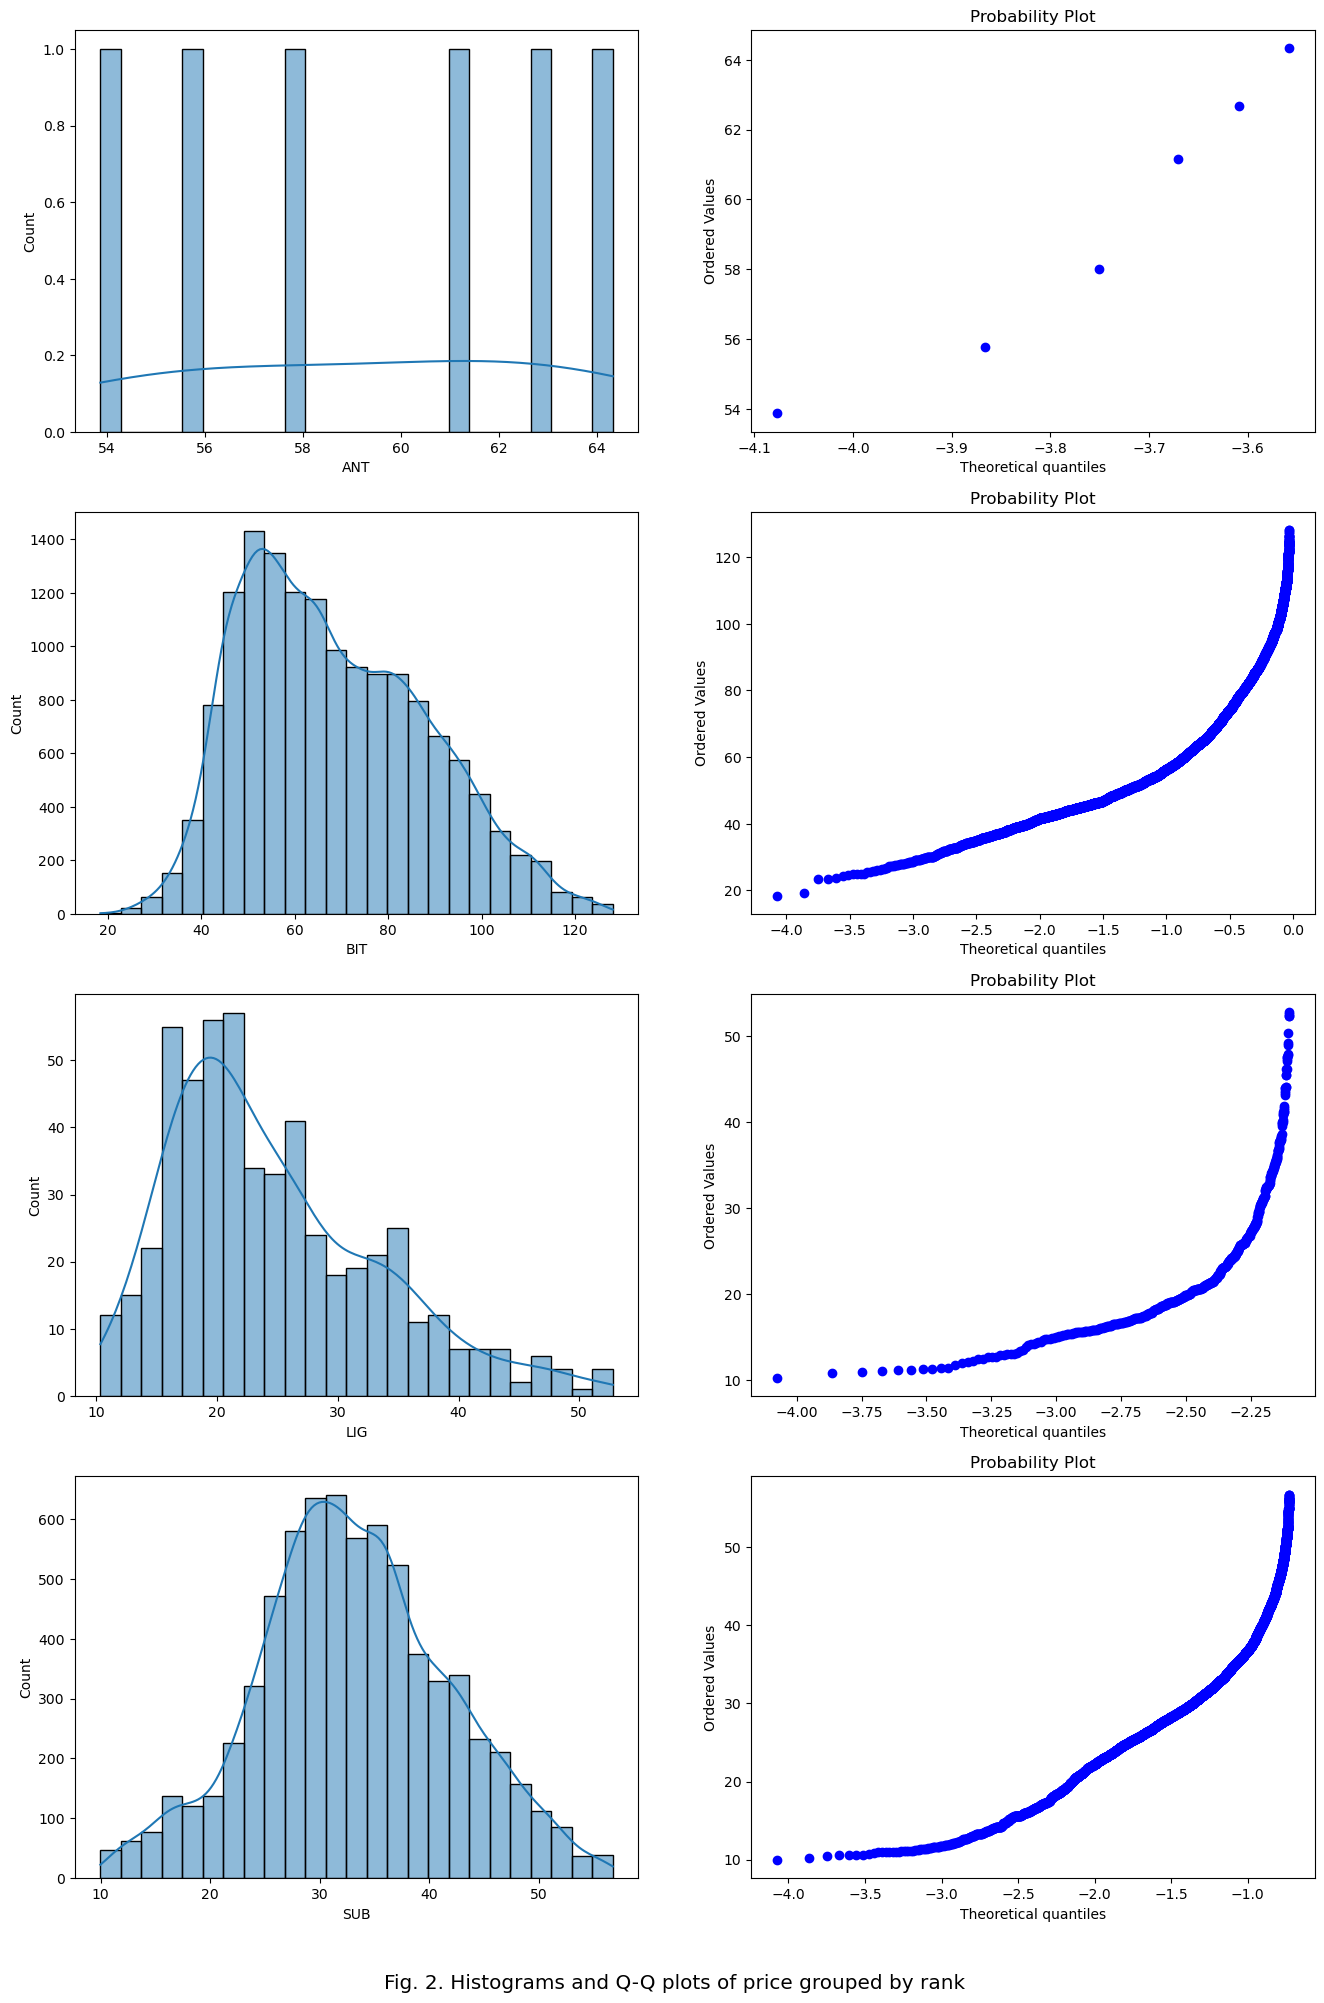

In [25]:
# Let's check if the price datapoints follow a normal distribution with histograms and Q-Q 
# plots.
import scipy.stats as stats

prices = [ant_prices, bit_prices, lig_prices, sub_prices]

plt.figure(figsize=(16,24))
for fig in range(0,8,2):
    plt.subplot(4,2,fig+1)
    sns.histplot(prices[int(fig/2)], bins=25, kde=True)
    plt.subplot(4,2,fig+2)
    stats.probplot(prices[int(fig/2)], dist='norm', plot=plt)
plt.suptitle('Fig. 2. Histograms and Q-Q plots of price grouped by rank', y=0.07, fontsize='x-large')
plt.show()

All the price distributions are right skewed, therefore we will use 'median' of each rank to impute respective missing prices.

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import shuffle


class StratifiedStatisticalImputer(BaseEstimator, TransformerMixin):
    """
    Impute statistical value (mean, median) to numerical columns based on categories from
    another column.

    Parameter
    ----------
    strategy : (str), default='mean'
        The Imputation strategy.

        - If 'mean', then replace missing values using mean of the values from that category.
          Can only be used with numeric data.
        - If 'median', then replace missing values using median of the values from that category.
          Can only be used with numeric data.

    random_state: (int), default=None
        Seed number to for reproducibility.

    split: (bool), default=False
        If True, transform method returns X and y seperately.
        If False, transform method returns Concatenated dataframe with last column being y.

    Attributes
    ----------
    features_ : list
        Predictors in the data.

    n_features_: int
        Number of features in the data.

    categories_: list
        Categories in categorical data.

    cardinality_: int
        Number of categories in categorical data.

    means_: dict
        Mean value of imputation for each category.

    medians_: dict
        Median value of imputation for each category.

    Returns
    -------
    imputed_data: Pandas DataFrame, of shape (n_samples, m_features + 1)
        The numerical data after imputation.

    Examples
    --------
    With NumPy arrays

    >>> X = np.array([2.62, np.nan, 10.51, 3.05, 11.10, 2.90, np.nan, 10.89])
    >>> y = np.array(['Tiger', 'Smilodon', 'Smilodon', 'Tiger', 'Smilodon', 'Tiger', 'Tiger', 'Smilodon'])

    >>> imputer = StratifiedStatisticalImputer(strategy='mean', random_state=16)
    >>> imputer.fit_transform(X, y)
              F0 category col
    0  11.100000     Smilodon
    1   2.620000        Tiger
    2  10.833333     Smilodon
    3  10.890000     Smilodon
    4   3.050000        Tiger
    5   2.856667        Tiger
    6   2.900000        Tiger
    7  10.510000     Smilodon

    With Pandas Series

    >>> X = pd.Series([2.62, np.nan, 10.51, 3.05, 11.10, 2.90, np.nan, 10.89], name='canine length(in)')
    >>> y = pd.Series(['Tiger', 'Smilodon', 'Smilodon', 'Tiger', 'Smilodon', 'Tiger', 'Tiger', 'Smilodon'], name='species')

    >>> imputer = StratifiedStatisticalImputer(strategy='median', random_state=16)
    >>> imputer.fit_transform(X, y)
        canine length(in)   species
    0              11.10  Smilodon
    1               2.62     Tiger
    2              10.89  Smilodon
    3              10.89  Smilodon
    4               3.05     Tiger
    5               2.90     Tiger
    6               2.90     Tiger
    7              10.51  Smilodon

    Warning
    -------
    The 'observations'(rows) will be shuffled.
    For example, if you take a single numerical variable and a categorical variable from a dataframe\n
    with mutiple variables, the output of transform or fit_transform methods result in a shuffled dataframe.\n 
    Therefore an attempt to combine this output with original dataframe may produce incorrect combination.\n
    Not to be used when X (inputs) has both categorical and numerical features.
    """
    allowed_strategies = ['mean', 'median']  # Class variable


    def __init__(self, strategy='mean', random_state=None, split=False):
        self.strategy = strategy
        self.random_state = random_state
        self.split = split
        strf_imp = StratifiedStatisticalImputer  # Alias for our long class name
        # allowed_startegies = ['mean', 'median']
        if self.strategy not in strf_imp.allowed_strategies:
            raise ValueError(
                "Can only use these strategies: {0} got strategy={1}".format(
                    strf_imp.allowed_strategies,
                    self.strategy
                    )
            )


    def _check_input_data(self, X, y): 
        X = np.array(X)
        y = np.array(y)


        # ------------------ Raise error when ------------------ #
        

        # 1. When length of the input arrays are unequal
        if len(X) != len(y):
            raise ValueError("All arrays must be same length")

        # Reshape X to (n_samples, 1_feature) if X.shape is (n_samples,).
        if X.shape == (len(X),):
            X = X.reshape(len(X), 1)
                   

        # 2. When y is not of shape (n_samples,) or (n_samples, 1_feature)
        if y.shape != (len(y),):
            try:
                y.reshape(len(y),)
            except ValueError:
                raise ValueError(
                    "Expected input array of shape {0} or {1}, got {2}. Provide array of shape either {0} or {1}".format
                    ((len(y),), (len(y), 1), y.shape)
                )
            else:
                y = y.reshape(len(y),)

        # 3. When dtype of y is not 'object' or 'unicode'
        if y.dtype.kind not in ['O', 'U']:
            raise TypeError(
                "Expected dtype: {0}, got {1}".format(['O', 'U'], y.dtype.kind)
            )

        # 4. When dtype of X is not float, and a type casting attempt fails.
        if X.dtype.kind not in ('f'):
            try:
                X.astype('float64')
            except ValueError:
                raise TypeError(
                    "Expected dtype: {0}, got {1}".format('float', X.dtype.kind)
                )
            else:
                X = X.astype('float64')
        else:
            X = X.astype('float64')
        
        return X, y


    def _check_X(self, X, fitted_X):
        X = np.array(X)

        # ------------------ Raise error when ------------------ #
        
        # 1. When X is not the same as fitted X
        if X.any() != fitted_X.any():
            raise ValueError("This algorithm is not inductive, provide the same X that was fitted.")
        
        return X


    def fit(self, X, y):
        """
        Fit the imputer on data.

        Parameters
        ----------
        X : (int, float) array-like, of shape (n_samples, m_feature) 
            The data that has missing values and is subjected to imputation.
        
        y : (Object, Unicode) array-like, of shape (n_samples, ) or (n_samples, 1_feature)
            A data that has categories. To store categories and fetch its row indices.

        Returns
        -------
        self : 
            Returns the fitted object.

        """
        if type(X) == pd.DataFrame:
            self.features_ = [col for col in X.columns]
        elif type(X) == pd.Series:
            if X.name == None:
                self.features_ = ['F0']
            else:    
                self.features_ = [X.name]
        elif X.shape == (len(X),):
            self.features_ = ['F0']    
        else:
            self.features_ = [f'F{x}' for x in range(X.shape[1])]

        if type(y) == pd.DataFrame:
            labels = [col for col in y.columns]
            self.label_name_ = labels[0]
        elif type(y) == pd.Series:
            if y.name == None:
                self.label_name_ = 'category col'
            else:    
                self.label_name_ = y.name  
        else:
            self.label_name_ = 'category col'

        strf_imp = StratifiedStatisticalImputer # Alias for our long class name
        X, y = self._check_input_data(X, y)

        # 1. Store number of features
        self.n_features_ = len(self.features_)

        # 2. Store unique values in y.
        self.categories_ = list(np.unique(y))

        # 3. Store cardinality of y.
        self.cardinality_ = len(np.unique(y))

        # Create a list of arrays that is grouped by y
        X_by_cat = []
        for cat in self.categories_:
            X_by_cat.append(X[y==cat])

        # 4. Store Mean value of imputation by category for each feature.
        self.means_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            if self.n_features_ == 1:
                means = np.nanmean(a=X_by_cat[cat], axis=0)
                self.means_.loc[cat] = {'Category': self.categories_[cat], self.features_[0]: float(means)}  
            else:
                means = np.nanmean(a=X_by_cat[cat], axis=0).tolist()
                self.means_.loc[cat] = [self.categories_[cat]] + means
        self.means_ = self.means_.set_index('Category')

        # 5. Store Median value of imputation for each category.
        self.medians_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            if self.n_features_ == 1:
                medians = np.nanmedian(a=X_by_cat[cat], axis=0) 
                self.medians_.loc[cat] = {'Category': self.categories_[cat], self.features_[0]: float(medians)} 
            else:
                medians = np.nanmedian(a=X_by_cat[cat], axis=0).tolist()
                self.medians_.loc[cat] = [self.categories_[cat]] + medians
        self.medians_ = self.medians_.set_index('Category')

        # 6. Save a copy of X
        self.X_ = X

        # 7. Save a copy of y
        self.y_ = y

        return self

    
    def transform(self, X):
        """
        Impute all missing values in `X`.

        Parameters
        ----------
        X : (int, float) array-like, of shape (n_samples, m_feature) 
            The data that has missing values and is subjected to imputation.

        Returns
        -------
        imputed_data : pandas DataFrame of shape (n rows, m + 1 columns)
            `num_data` with imputed values

        """
        strf_imp = StratifiedStatisticalImputer # Alias for our long class name
        check_is_fitted(self, ['features_', 'n_features_', 'categories_', 'cardinality_', 'means_', 'medians_', 'X_', 'y_'])
        X = self._check_X(X, self.X_)

        if X.shape == (len(X),):
            X = X.reshape(-1, 1)  

        # TODO: Create a list of arrays that is grouped by y ✔
        X_by_cat = []
        for cat in self.categories_:
            X_by_cat.append(X[self.y_==cat])

        # TODO: Impute missing values ✔
        cat_df = []
        for cat in range(len(self.categories_)):
            imputed_data = pd.DataFrame()
            for feature in range(len(self.features_)):
                if self.strategy == strf_imp.allowed_strategies[0]:
                    imputation_value = self.means_.iloc[cat, feature]
                elif self.strategy == strf_imp.allowed_strategies[1]:
                    imputation_value = self.medians_.iloc[cat, feature]
                
                arr = X_by_cat[cat][:, feature]
                arr[np.isnan(arr)] = imputation_value

                imputed_data[self.features_[feature]] = arr
            cat_df.append(imputed_data)

        imputed_df = pd.concat(cat_df)

        # TODO: Assign categorical variables accordingly ✔
        y_new = []
        for cat in range(len(self.categories_)):
            labels = [self.categories_[cat]] * len(X_by_cat[cat])
            y_new.append(labels)

        y_new = sum(y_new, [])
        imputed_df[self.label_name_] = y_new

        # TODO: Randomly shuffle the row indices ✔
        imputed_df = shuffle(imputed_df, random_state=self.random_state)
        imputed_df = imputed_df.reset_index(drop=True)

        # TODO: Split or not ✔
        if self.split:
            data = imputed_df.drop(self.label_name_, axis=1)
            labels = imputed_df[self.label_name_]
            return data, labels
        else:
            return imputed_df


In [27]:
# Create an instance of the imputer and impute
imputer = StratifiedStatisticalImputer(strategy='median', random_state=16, split=False)
imputed_price_data = imputer.fit_transform(X=coal_eda['price'], y=coal_eda['rank'])
imputed_price_data

,price,rank
0,65.53,BIT
1,49.09,BIT
2,32.79,SUB
3,32.79,SUB
4,65.82,BIT
...,...,...
30423,77.69,BIT
30424,60.08,BIT
30425,65.53,BIT
30426,65.53,BIT


In [28]:
imputed_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30428 entries, 0 to 30427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   30428 non-null  float64
 1   rank    30428 non-null  object 
dtypes: float64(1), object(1)
memory usage: 475.6+ KB


We built an imputer that can impute missing values in X, provided X is 'numerical' and y is 'categorical'. This resulted in a shuffled (rows) dataframe. We can use it later in the Transformation Pipeline to handle similar situation. 

Now that the price of different coal ranks is analysed, we could keep it for training classification models, however price as a predictor is liable to decreased performance of a model due to price drift (data drift). Considering the potential danger, we shall remove it from the dataframe and not use it for training classification models. Nevertheless, we got a rough understanding of pricing.

In [29]:
# Remove price from coal_eda
coal_eda = coal_eda.drop('price', axis=1)

In [30]:
coal_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30428 entries, 0 to 30427
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   period                 30428 non-null  object 
 1   location               30428 non-null  object 
 2   plantStateDescription  30428 non-null  object 
 3   plant                  30428 non-null  int64  
 4   plantName              30428 non-null  object 
 5   rank                   30428 non-null  object 
 6   coalRankDescription    30428 non-null  object 
 7   ash-content            30428 non-null  float64
 8   heat-content           30428 non-null  int64  
 9   quantity               30428 non-null  int64  
 10  sulfur-content         30428 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 2.6+ MB


All Variables look ready for analysis.

## **How has the coal production changed since 2001?**

In [31]:
# Arrange the data in descending order of period (old to New).
coal_prod = US_coal_mines_org[['period', 'production']].sort_values(by=['period'], ascending=True)
coal_prod['period'] = coal_prod['period'].astype(str)
coal_prod

,period,production
0,2001,7001405
1419,2001,290201
1418,2001,9304
1417,2001,1416151
1416,2001,0
...,...,...
34133,2021,0
34134,2021,0
34135,2021,0
34124,2021,0


In [32]:
# Group by year
qty_by_period = coal_prod.groupby('period', as_index=False)['production'].sum()

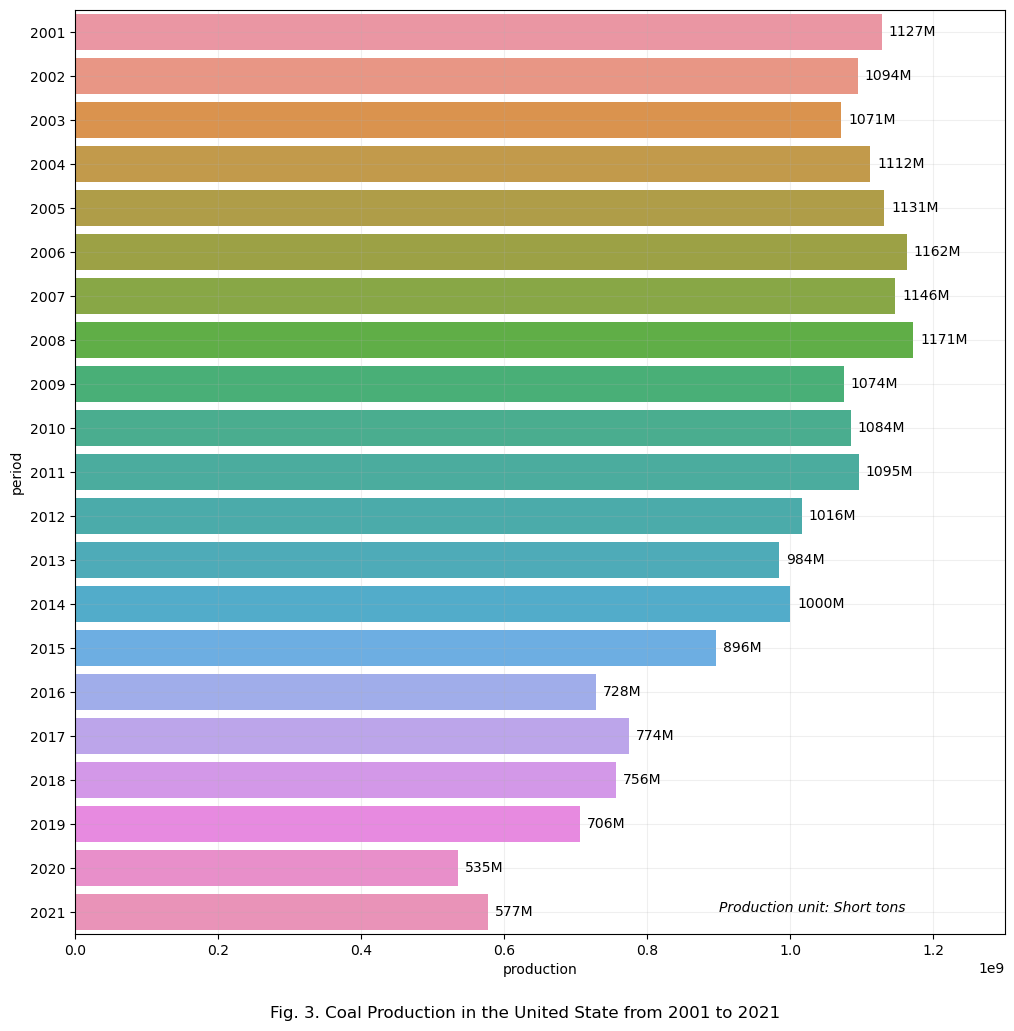

In [33]:
plt.figure(figsize=(12,12))
# sns.barplot(x='period', y='quantity', data=qty_by_period)
# sns.lineplot(x='period', y='quantity', data=qty_by_period)
ax = sns.barplot(x='production', y='period', data=qty_by_period)
# plt.xticks(rotation=90)
bar_values = qty_by_period['production'].astype(str).to_list()
for index in range(len(bar_values)):
    bar_values[index] = bar_values[index][0:-6] + 'M' # floor of the number.

for bar_cont in ax.containers:
    ax.bar_label(bar_cont,labels=bar_values, padding=5)
plt.grid(alpha=0.2)
plt.xlim(0,1.3e9)
plt.text(0.9e9, 20, 'Production unit: Short tons', fontdict={'fontstyle':'italic'})
plt.suptitle('Fig. 3. Coal Production in the United State from 2001 to 2021', y=0.05)
plt.show()

In [34]:
print('Data shows a downward trend.')
print("Production in 2001: {0}M short tons\nProduction in 2021: {1}M short tons".format(bar_values[0][0:-1], bar_values[-1][0:-1]))
print("Coal production in the US decreased by a factor of {:.2f} from 2001 to 2021.".format(qty_by_period['production'][0]/qty_by_period['production'][len(qty_by_period['production'])-1]))

Data shows a downward trend.
Production in 2001: 1127M short tons
Production in 2021: 577M short tons
Coal production in the US decreased by a factor of 1.95 from 2001 to 2021.


### **<font color=Orange>Checkpoint</font>**

In [35]:
# Create a checkpoint here, so that if any preprocessing goes wrong down the line,
# you can save yourself a lot of trouble by not having to run all the cells from the 
# point where the data was initially loaded. 
coal_EDA = coal_eda.copy() # This line of code is what i meant by checkpoint.

## **Split the Data into Train and Test Sets**

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

X = coal_EDA.drop('rank', axis=1)
y = coal_EDA['rank']

ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in ss_split.split(X, y):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

In [37]:
coal_EDA = pd.concat([X_train, y_train], axis=1)

## **Handling Outliers**

In [38]:
# Remove and rearrange some of the columns.
coal_imbal = coal_EDA[['ash-content', 'sulfur-content', 'heat-content', 'rank']]
coal_imbal.head()

,ash-content,sulfur-content,heat-content,rank
25753,9.50,1.15,12543,BIT
17199,11.20,0.68,6217,LIG
11074,4.45,0.21,8800,SUB
10778,8.96,2.14,11918,BIT
2422,9.43,1.04,6684,LIG


In [39]:
# Group variables by rank
ash_by_rank = coal_imbal.pivot(columns='rank', values='ash-content')
sulfur_by_rank = coal_imbal.pivot(columns='rank', values='sulfur-content')
heat_by_rank = coal_imbal.pivot(columns='rank', values='heat-content')

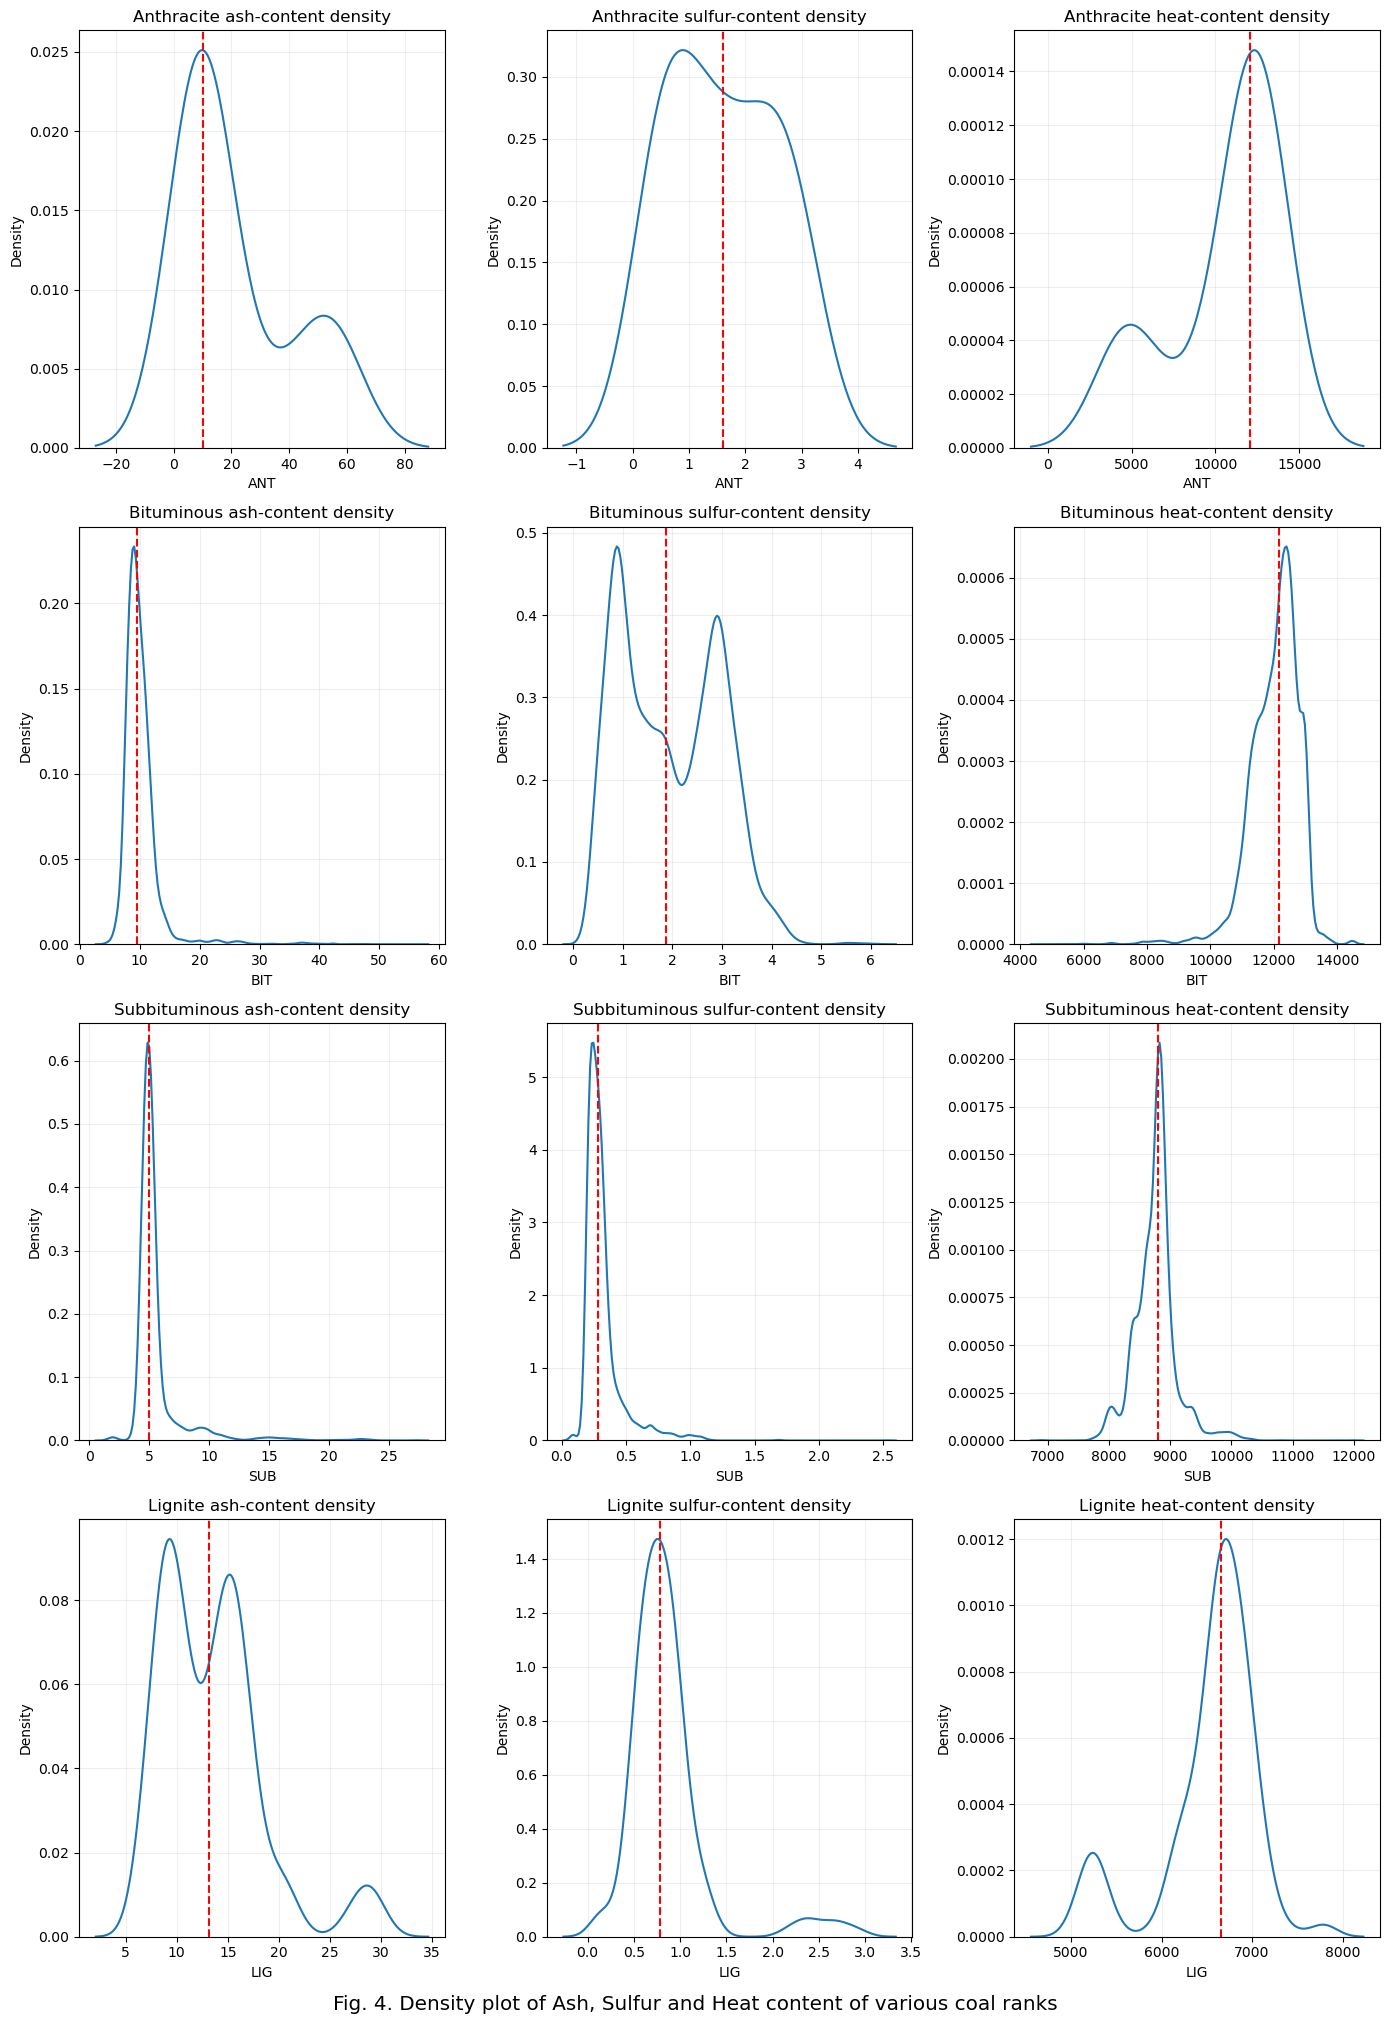

In [40]:
plt.subplots(4, 3, figsize = (14,20))

coal_types = ['Anthracite', 'Bituminous', 'Subbituminous', 'Lignite']
coal_id = ['ANT', 'BIT', 'SUB', 'LIG']


for name, fig in zip(range(len(coal_types)), range(1, 13, 3)):
    plt.subplot(4,3,fig)
    sns.kdeplot(data=ash_by_rank[coal_id[name]])
    plt.grid(alpha=0.2)
    plt.title(f'{coal_types[name]} ash-content density')
    plt.axvline(x=np.nanmedian(ash_by_rank[coal_id[name]]), color='red', linestyle='--')

    plt.subplot(4,3,fig+1)
    sns.kdeplot(data=sulfur_by_rank[coal_id[name]])
    plt.grid(alpha=0.2)
    plt.title(f'{coal_types[name]} sulfur-content density')
    plt.axvline(x=np.nanmedian(sulfur_by_rank[coal_id[name]]), color='red', linestyle='--')

    plt.subplot(4,3,fig+2)
    sns.kdeplot(data=heat_by_rank[coal_id[name]])
    plt.grid(alpha=0.2)
    plt.title(f'{coal_types[name]} heat-content density')
    plt.axvline(x=np.nanmedian(heat_by_rank[coal_id[name]]), color='red', linestyle='--')

plt.tight_layout()
plt.suptitle('Fig. 4. Density plot of Ash, Sulfur and Heat content of various coal ranks', y=0, fontsize='x-large')
plt.show()

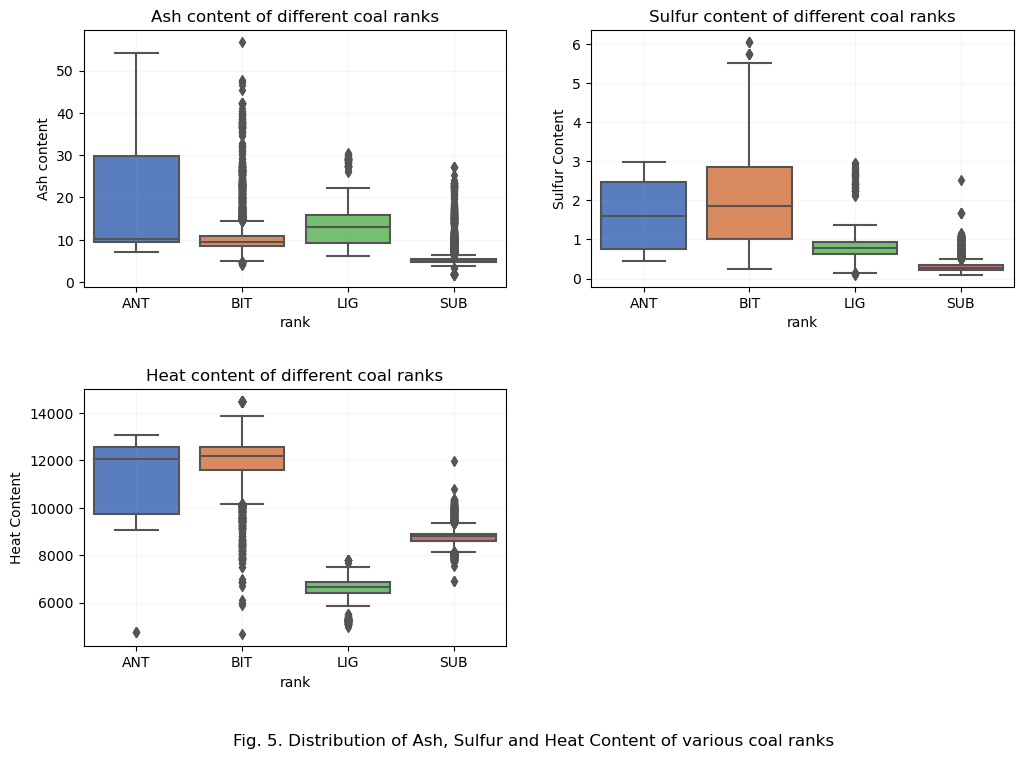

In [41]:
fig, ax = plt.subplots(2,2, figsize = (12,8))

plt.subplot(2,2,1)
sns.boxplot(data=ash_by_rank, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Ash content')
plt.title('Ash content of different coal ranks')

plt.subplot(2,2,2)
sns.boxplot(data=sulfur_by_rank, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Sulfur Content')
plt.title('Sulfur content of different coal ranks')

plt.subplot(2,2,3)
sns.boxplot(data=heat_by_rank, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Heat Content')
plt.title('Heat content of different coal ranks')

fig.delaxes(ax[1, 1])

plt.subplots_adjust(hspace=0.4)
plt.suptitle('Fig. 5. Distribution of Ash, Sulfur and Heat Content of various coal ranks', y=0)
plt.show()

The dataframe has three features and 4 target classes. Some of the feature instances are outliers. We need to remove those observations from the dataframe wherein either of the three features identify as an outlier of that particular class. 

In [42]:
class MultivariateStratifiedOutlierRemover(BaseEstimator, TransformerMixin):
    """
    Removes data points that fall outside of hyperrectangles defined by strata based on IQR(1.5) or IQR(3) 
    proximity rule.

    Parameters
    ----------
    strategy : (float), default=1.5
        The rule to compute outliers.

        - If 1.5, then compute outliers based on inter-quartile-range(1.5) proximity rule. 
        - If 3, then compute extreme values based on inter-quartile-range(3) proximity rule.

    random_state: (int), default=None
        Specify the seed for random number generation.

    split: (bool), default=False
        If True, transform method returns X and y seperately.
        If False, transform method returns concatenated dataframe with last column being y. 

    X : (numerical) array-like of shape (n_samples, m_features)
        Features or variables in the data.
        
    y : (categorical) array-like of shape (n_samples, 1_feature)
        Data that has categories.

    Attributes
    ----------
    features_: list
        if X is a Pandas DataFrame, display a list of features, else outputs 'None'.

    label_name_: list
        if y is a Pandas DataFrame, display the name of the column, else display 'category col'.

    n_samples_: int
        Number of samples

    n_features_: int
        Number of features

    categories_: list
        Categories in categorical data.

    cardinality_: int
        Number of categories in categorical data.

    IQR_: pd.DataFrame
        Interquartile range

    minima_: pd.DataFrame
        Minimums of variables.

    first_quartiles_: pd.DataFrame
        First quartiles or 25th Percentiles of the variables. 

    medians_: pd.DataFrame
        Median value of imputation for each category.

    third_quartiles_: pd.DataFrame
        Third quartiles or 75th Percentiles of the variables.
    
    maxima_: pd.DataFrame
        Maximums of variables.

    percent_: dict
        Percentage of outliers grouped by category in the variables.

    loss_: int
        Number of observations that will be removed.

    normalized_loss_: float
        Percentage of observations that will be removed.


    Returns
    -------
    Pandas DataFrame, of shape (n_samples_ - loss_, m_features_)
        The data after outlier removal.

    Warning!
    -------
    The order of 'observations'(rows) will be shuffled.
    For example, if you take a single numerical variable and a categorical variable from a dataframe\n
    with mutiple variables, the output of transform or fit_transform methods result in a shuffled dataframe.\n 
    Therefore an attempt to combine this output with original dataframe may produce incorrect combination.\n
    Not to be used when X (inputs) has both categorical and numerical features.    
    """
    allowed_strategies = [1.5, 3]  # Class variable


    def __init__(self, strategy=1.5, random_state = None, split=False):
        self.strategy = strategy
        self.random_state = random_state
        self.split = split
        MOR = MultivariateStratifiedOutlierRemover  # Alias
        if self.strategy not in MOR.allowed_strategies:
            raise ValueError(
                "Can only use these strategies: {0} got strategy={1}".format(
                    MOR.allowed_strategies,
                    self.strategy
                    )
            )


    def _check_input_data(self, X, y):  
        X = np.array(X)
        y = np.array(y)

        # ------------------ Raise error when ------------------ #
        

        # 1. When length of the input arrays are unequal
        if len(y) != len(X):
            raise ValueError("All arrays must be same length")

        # Reshape X to (n_samples, 1_feature) if X.shape is (n_samples,).
        if X.shape == (len(X),):
            X = X.reshape(len(X), 1)

        # 2. When y is not of shape (n_samples,) or (n_samples, 1_feature)
        if y.shape != (len(y),):
            try:
                y.reshape(len(y),)
            except ValueError:
                raise ValueError(
                    "Expected input array of shape {0} or {1}, got {2}. Provide array of shape either {0} or {1}".format
                    ((len(y),), (len(y), 1), y.shape)
                )
            else:
                y = y.reshape(len(y),)

        # 3. When dtype of y is not 'object' or 'unicode'
        if y.dtype.kind not in ['O', 'U']:
            raise TypeError(
                "Expected dtype: {0}, got {1}".format(['O', 'U'], y.dtype.kind)
            )

        # 4. When dtype of X is not float, and a type casting attempt fails.
        if X.dtype.kind not in ['i', 'f']:
            try:
                X.astype('float64')
            except ValueError:
                raise TypeError(
                    "Expected dtype: {0}, got {1}".format('float', X.dtype.kind)
                )
            else:
                X = X.astype('float64')
        else:
            X = X.astype('float64')
        
        return X, y


    def _check_X(self, X, fitted_X): 
        X = np.array(X)

        # ------------------ Raise error when ------------------ #
        
        # 1. When X is not the same as fitted X
        if X.any() != fitted_X.any():
            raise ValueError("This algorithm is not inductive, provide the same X that was fitted.")
        
        return X


    def fit(self, X, y):
        """
        Fit the remover on data.

        Parameters
        ----------
        X : (numerical) array-like of shape (n_samples, m_features)
            Features or variables in the data.
        
        y : (categorical) array-like of shape (n_samples, 1_feature)
            Data that has categories.
 
        Returns
        -------
        self:
            Returns the fitted object
        """
        if type(X) == pd.DataFrame:
            self.features_ = [col for col in X.columns]
        elif type(X) == pd.Series:
            if X.name == None:
                self.features_ = ['F0']
            else:    
                self.features_ = [X.name]
        elif X.shape == (len(X),):
            self.features_ = ['F0']
        else:
            self.features_ = [f'F{x}' for x in range(X.shape[1])]

        if type(y) == pd.DataFrame:
            labels = [col for col in y.columns]
            self.label_name_ = labels[0]
        elif type(y) == pd.Series:
            if y.name == None:
                self.label_name_ = 'category col'
            else:
                self.label_name_ = y.name
        else:
            self.label_name_ = 'category col'

        X, y = self._check_input_data(X, y)

        # TODO: Store number of samples ✔
        self.n_samples_ = len(y)

        # TODO: Store number of features ✔
        self.n_features_ = X.shape[1]

        # TODO: Store categories ✔
        self.categories_ = list(np.unique(y))

        # TODO: Store number of categories ✔
        self.cardinality_ = len(np.unique(y))

        # TODO: Create a list of arrays that is grouped by y ✔
        X_by_cat = []
        for cat in self.categories_:
            X_by_cat.append(X[y==cat])   

        # TODO: Store interquartile range by category ✔
        self.IQR_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            iqr = (np.quantile(a=X_by_cat[cat], q=0.75, axis=0) - np.quantile(a=X_by_cat[cat], q=0.25, axis=0)).tolist()
            self.IQR_.loc[cat] = [self.categories_[cat]] + iqr
        self.IQR_ = self.IQR_.set_index('Category')

        # TODO: Store minima of the variables by category ✔
        self.minima_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            # To find minima, use formula -> minima = 25th quantile - IQR * 1.5 
            minima =  (np.quantile(a=X_by_cat[cat], q=0.25, axis=0) - ((np.quantile(a=X_by_cat[cat], q=0.75, axis=0) - np.quantile(a=X_by_cat[cat], q=0.25, axis=0)) * self.strategy)).tolist()
            self.minima_.loc[cat] = [self.categories_[cat]] + minima
        self.minima_ = self.minima_.set_index('Category')

        # TODO: Store first quartiles of the variables by category ✔
        self.first_quartiles_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            first_quartiles = np.quantile(a=X_by_cat[cat], q=0.25, axis=0).tolist()
            self.first_quartiles_.loc[cat] = [self.categories_[cat]] + first_quartiles
        self.first_quartiles_ = self.first_quartiles_.set_index('Category')

        # TODO: Store medians of the variables by category ✔
        self.medians_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            medians = np.median(a=X_by_cat[cat], axis=0).tolist()
            self.medians_.loc[cat] = [self.categories_[cat]] + medians
        self.medians_ = self.medians_.set_index('Category')

        # TODO: Store third quartiles of the variables by category ✔
        self.third_quartiles_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            third_quartiles = np.quantile(a=X_by_cat[cat], q=0.75, axis=0).tolist()
            self.third_quartiles_.loc[cat] = [self.categories_[cat]] + third_quartiles
        self.third_quartiles_ = self.third_quartiles_.set_index('Category')

        # TODO: Store maxima of the variables by category ✔
        self.maxima_ = pd.DataFrame(columns= ['Category'] + self.features_)
        for cat in range(len(self.categories_)):
            # To find maxima, use formula -> maxima = 75th quantile + IQR * 1.5 
            maxima =  (np.quantile(a=X_by_cat[cat], q=0.75, axis=0) + ((np.quantile(a=X_by_cat[cat], q=0.75, axis=0) - np.quantile(a=X_by_cat[cat], q=0.25, axis=0)) * self.strategy)).tolist()
            self.maxima_.loc[cat] = [self.categories_[cat]] + maxima
        self.maxima_ = self.maxima_.set_index('Category')

        # TODO: Store indices of rows having outliers ✔
        self.outlier_indices_ = []
        for cat in range(len(self.categories_)):
            outlier_cells = []
            for col in range(len(self.features_)):
                cells = np.where(
                    np.where(
                        X_by_cat[cat].T[col] > self.maxima_.iloc[cat, col],
                        True,
                        np.where(X_by_cat[cat].T[col] < self.minima_.iloc[cat, col], True, False)
                    )
                )[0].tolist()
                outlier_cells.append(cells)
            cat_outlier_indices = list(set(sum(outlier_cells, [])))
            self.outlier_indices_.append(cat_outlier_indices)

        # TODO: Store percentage of rows having outliers ✔
        self.percent_ = {}
        for cat in range(len(self.categories_)):
            perc = round( len(self.outlier_indices_[cat]) / len(X_by_cat[cat]) * 100, 2 )
            self.percent_[self.categories_[cat]] = perc

        # TODO: Store number of rows having outliers ✔
        self.loss_ = len(sum(self.outlier_indices_, []))

        # TODO: Store percentage of rows having outliers ✔
        self.normalized_loss_ = round(self.loss_/len(y), 2)

        # TODO: Store a copy of 'y' ✔
        self.y_ = y

        # TODO: Store a copy of 'X' ✔
        self.X_ = X

        return self


    def transform(self, X):
        """
        Removes outliers based on the learned attributes.

        Parameters:
        -----------

        X: (numerical) array-like of shape (n_samples, m_features)
            Features or variables in the data to be Transformed.

        Returns:
        --------
        
        Pandas DataFrame, of shape (n_samples_ - loss_ , m_features_ + 1 column)
            The Data after outlier removal.
        """
        check_is_fitted(self, ['features_', 'label_name_', 'n_samples_', 'n_features_', 'categories_','cardinality_','IQR_','minima_','first_quartiles_','medians_','third_quartiles_','maxima_','outlier_indices_','percent_', 'loss_', 'normalized_loss_', 'y_', 'X_'])
        X = self._check_X(X, self.X_)

        if X.shape == (len(X),):
            X = X.reshape(-1, 1)
        
        # TODO: Create a list of arrays that is grouped by y ✔
        X_by_cat = []
        for cat in self.categories_:
            X_by_cat.append(X[self.y_==cat])

        # TODO: Based on the index postions in self.outlier_indices_, remove the marked observations from X_by_cat array ✔
        X_by_cat_remv = []
        for cat in range(len(self.categories_)):
            X_remv = np.delete(X_by_cat[cat], self.outlier_indices_[cat], axis=0)
            X_by_cat_remv.append(X_remv)


        # TODO: Assign the categorical variable accordingly ✔
        y_new = []
        for cat in range(len(self.categories_)):
            labels = [self.categories_[cat]] * len(X_by_cat_remv[cat])
            y_new.append(labels)

        X_by_cat_remv = np.vstack(X_by_cat_remv)
        y_new = sum(y_new, [])

        # TODO: Convert to a Dataframe ✔
        data_removed = pd.DataFrame(data=X_by_cat_remv, columns=self.features_)
        data_removed[self.label_name_] = np.array(y_new).reshape(-1, 1)

        # TODO: Randomly shuffle the row indices ✔
        data_removed = shuffle(data_removed, random_state=self.random_state)

        # TODO: Split or not ✔
        if self.split:
            data = data_removed.drop(self.label_name_, axis=1)
            labels = data_removed[self.label_name_]
            return data, labels
        else:
            return data_removed


In [43]:
X = coal_imbal.drop('rank', axis=1)
y = coal_imbal['rank'].to_frame() # Converting to a dataframe to preserve the column name. Refer docstring.

In [44]:
# Create and object of the 'MultivariateStartifiedOutlierRemover' class to remove the outliers.
remover = MultivariateStratifiedOutlierRemover(strategy=1.5, random_state=42, split=False)
coal_imbal_remv = remover.fit_transform(X, y)
coal_imbal_remv

,ash-content,sulfur-content,heat-content,rank
4159,8.91,0.93,11984.0,BIT
18356,5.17,0.25,8830.0,SUB
14669,7.91,0.88,13040.0,BIT
3473,8.45,0.49,11660.0,BIT
20543,5.48,0.28,8894.0,SUB
...,...,...,...,...
11964,8.96,3.07,12663.0,BIT
21575,4.87,0.23,8783.0,SUB
5390,11.02,0.99,12346.0,BIT
860,10.10,0.97,12396.0,BIT


In [45]:
coal_imbal_remv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22128 entries, 4159 to 15795
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ash-content     22128 non-null  float64
 1   sulfur-content  22128 non-null  float64
 2   heat-content    22128 non-null  float64
 3   rank            22128 non-null  object 
dtypes: float64(3), object(1)
memory usage: 864.4+ KB


In [46]:
remover.loss_, remover.normalized_loss_

(2214, 0.09)

The data had 24342 observations, the 'remover' object identified 2214 (all classes combined) observations as outliers which is 9% of the total and removed it. Let's plot the new data and see if there are any issues.

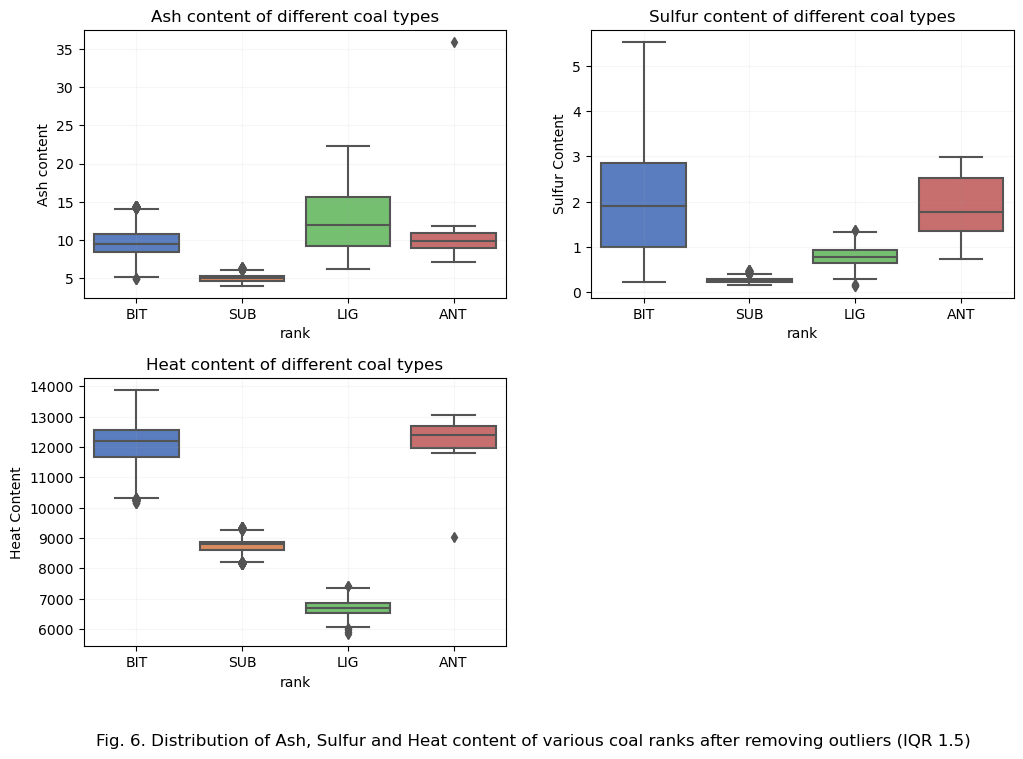

In [47]:
fig, ax = plt.subplots(2,2, figsize = (12,8))

plt.subplot(2,2,1)
sns.boxplot(x='rank',y='ash-content',data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Ash content')
plt.title('Ash content of different coal types')

plt.subplot(2,2,2)
sns.boxplot(x='rank', y='sulfur-content', data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Sulfur Content')
plt.title('Sulfur content of different coal types')

plt.subplot(2,2,3)
sns.boxplot(x='rank', y='heat-content', data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Heat Content')
plt.title('Heat content of different coal types')
plt.subplots_adjust(hspace=0.3)

fig.delaxes(ax[1, 1])
plt.suptitle('Fig. 6. Distribution of Ash, Sulfur and Heat content of various coal ranks after removing outliers (IQR 1.5)', y=0)
plt.show()

I'm skeptical about the validity of anthracite's distribution.

In Fig. 6. let's consider 'Heat content', the full range is from approximately 4800 to 13000 BTU/lb. However, measured values are roughly between 13000 to 15000 BTU/lb. The plots, especially the subplot in Fig. 4. 'Anthracite heat-content KDE' shows there's a subset of anthracite population that is centering around 4800 BTU/lb. One possible explanation for this is low-energy-value discard of the coal also called 'Coal waste' or 'Coal refuse'. Let us further clean the anthracite values, this time we will discard all values from anthracite whose heat content is less than 10000 BTU/lb.

In [48]:
mask = (coal_imbal_remv['rank'] == 'ANT') & (coal_imbal_remv['heat-content'] < 10000.0)
coal_imbal_remv = coal_imbal_remv[~mask]
coal_imbal_remv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22127 entries, 4159 to 15795
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ash-content     22127 non-null  float64
 1   sulfur-content  22127 non-null  float64
 2   heat-content    22127 non-null  float64
 3   rank            22127 non-null  object 
dtypes: float64(3), object(1)
memory usage: 864.3+ KB


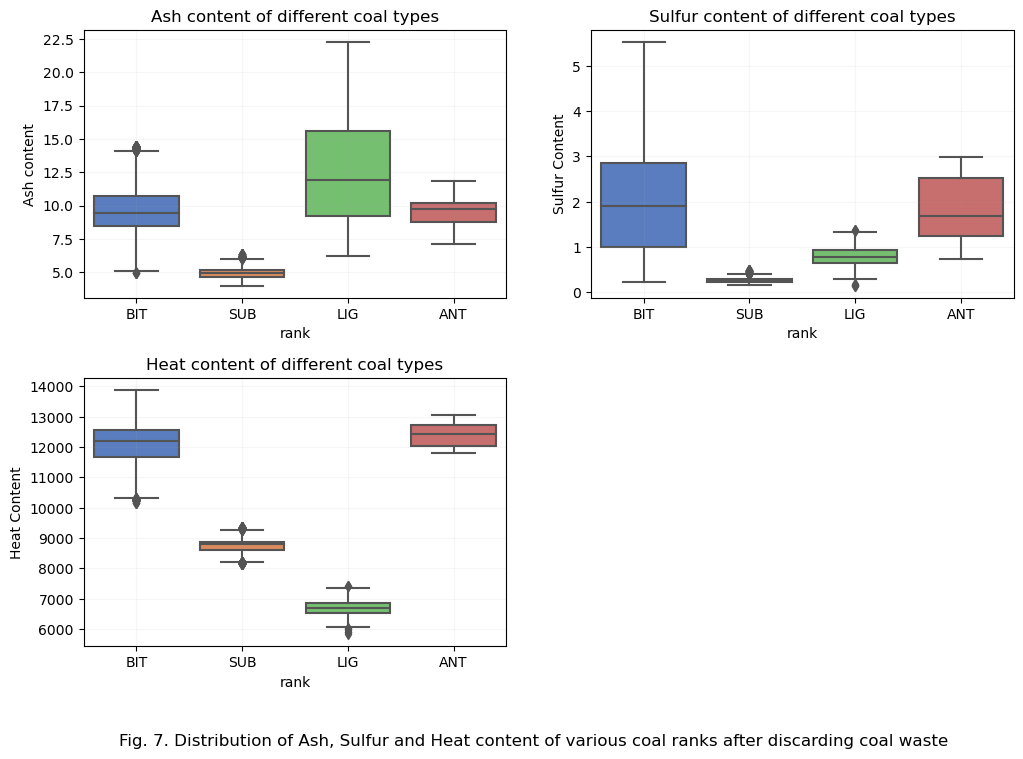

In [49]:
fig, ax = plt.subplots(2,2, figsize = (12,8))

plt.subplot(2,2,1)
sns.boxplot(x='rank',y='ash-content',data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Ash content')
plt.title('Ash content of different coal types')

plt.subplot(2,2,2)
sns.boxplot(x='rank', y='sulfur-content', data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Sulfur Content')
plt.title('Sulfur content of different coal types')

plt.subplot(2,2,3)
sns.boxplot(x='rank', y='heat-content', data=coal_imbal_remv, palette='muted')
plt.grid(alpha=0.1)
plt.ylabel('Heat Content')
plt.title('Heat content of different coal types')
plt.subplots_adjust(hspace=0.3)

fig.delaxes(ax[1, 1])
plt.suptitle('Fig. 7. Distribution of Ash, Sulfur and Heat content of various coal ranks after discarding coal waste', y=0)
plt.show()

In [50]:
# CHECKPOINT
coal_imbal = coal_imbal_remv.copy()

## **Handling Imbalance in the Data**

Let's look at the distribution of classes (rank) in the dataset.

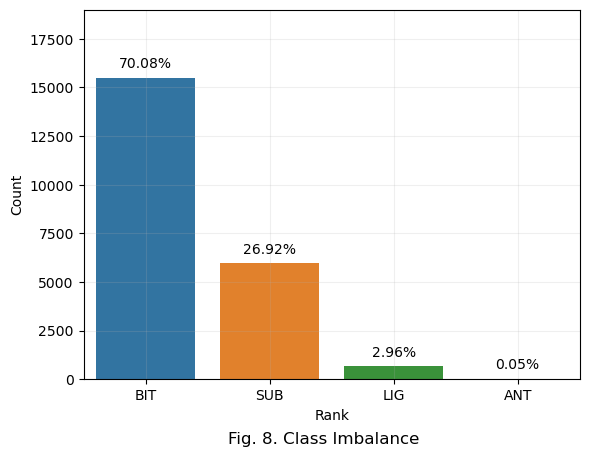

In [51]:
coal_rank_distb = coal_imbal['rank'].value_counts().to_frame(name='Count').reset_index() # 'names' parameter in the reset_index() isn't working!
ax = sns.barplot(x='index', y='Count', data=coal_rank_distb)
plt.grid(alpha=0.2)
plt.ylim(bottom=0, top=19000)
bar_values =[value + '%' for value in round(coal_imbal['rank'].value_counts(normalize=True)*100, 2).to_numpy().astype(str)]
for container in ax.containers:
    ax.bar_label(container,labels=bar_values, padding=5)
plt.xlabel('Rank')
plt.suptitle('Fig. 8. Class Imbalance', y=0)
plt.show()

In [52]:
len(coal_imbal[coal_imbal['rank'] == 'ANT'])

10

Anthracite is less than 1% of the total observations. To be precise, we only have 10 out of 22128 (0.05% )observations. The plots in Fig. 7. shows that Anthracite and Bituminous have overlapping range for all three of its features, but historically, anthracite has been observed to be a superior fuel. This implies the antharcite observations in the data might not be representative of its population. For this reason its best to exclude the Antharcites and only build classification model for rest of the ranks. 

In [53]:
coal_prepro = coal_imbal[coal_imbal['rank'] != 'ANT']
coal_prepro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22117 entries, 4159 to 15795
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ash-content     22117 non-null  float64
 1   sulfur-content  22117 non-null  float64
 2   heat-content    22117 non-null  float64
 3   rank            22117 non-null  object 
dtypes: float64(3), object(1)
memory usage: 863.9+ KB


To fix imbalance in other categories, we will use **SMOTE** (**S**ynthetic **M**inority **O**versampling **TE**chnique) to 'oversample' less frequent classes.

In [54]:
from imblearn.over_sampling import SMOTE

coal_imbal_X = coal_prepro.drop('rank', axis=1)
coal_imbal_y = coal_prepro['rank']

smote = SMOTE(random_state=42)
coal_bal_X , coal_bal_y = smote.fit_resample(coal_imbal_X, coal_imbal_y)

In [55]:
coal_bal_X.shape, coal_bal_y.shape

((46518, 3), (46518,))

In [56]:
round(coal_bal_y.value_counts(normalize=True), 2)

BIT    0.33
SUB    0.33
LIG    0.33
Name: rank, dtype: float64

Now that we handled imbalance in the data, let us prepare it for further statistical tests. 

In [57]:
coal_bal = pd.concat([coal_bal_X, coal_bal_y], axis=1)

In [58]:
# CHECKPOINT
coal_EDA_bal = coal_bal.copy()

## **Correlation and Statistical Tests**

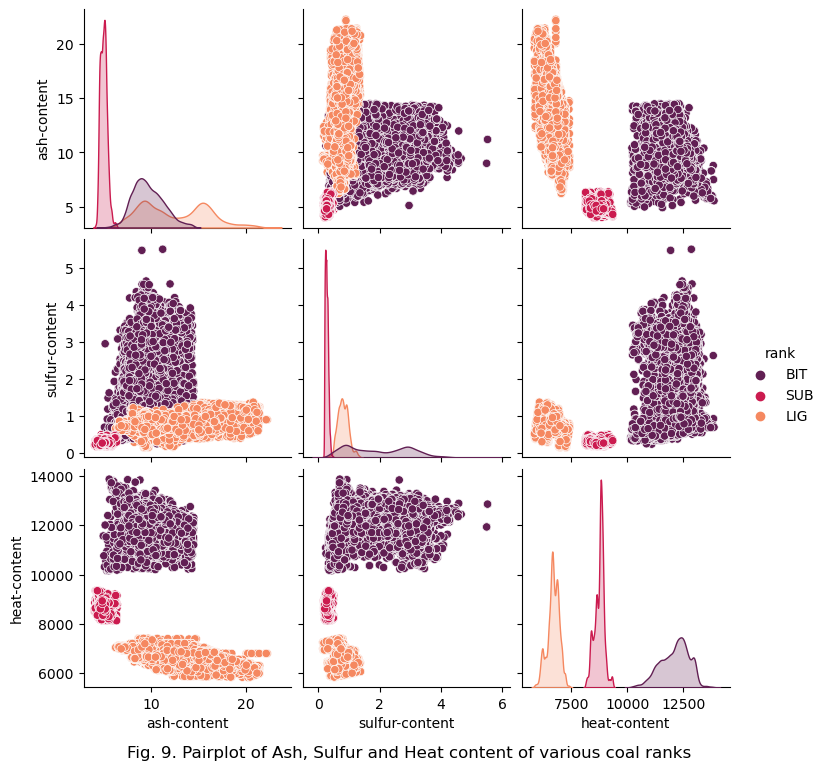

In [59]:
sns.pairplot(data=coal_EDA_bal, hue='rank', palette='rocket')
plt.suptitle('Fig. 9. Pairplot of Ash, Sulfur and Heat content of various coal ranks', y=0)
plt.show()

From the pairplot we can infer that the three types of coal can be distinguished with their heat content.

Let's plot a Heat map to get a general understanding of the relationship between variables.

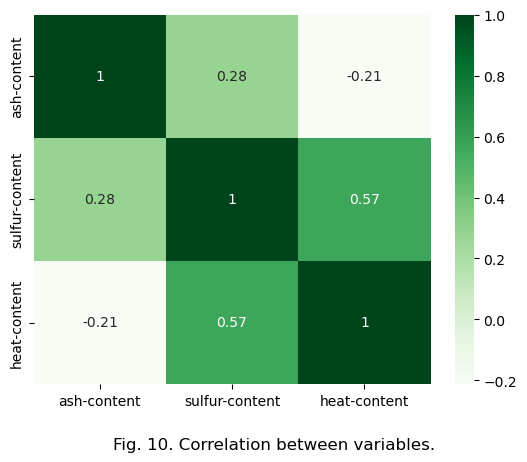

In [60]:
corr = coal_EDA_bal.corr()

sns.heatmap(corr, annot=True, cmap='Greens')
plt.suptitle('Fig. 10. Correlation between variables.', y=0)
plt.show()

heat-content and ash-content are negatively correlated. This means "high grade" fuels leave less Ash.

The dependent variable is 'rank', it has 3 categories. The table below shows different statistical tests to be performed based on datatypes of independent variables and dependent variable.

|Sl.No|Variables|Type of data|Statistical test|
|:-:|:-:|:-:|:-:|
|1.|ash-content|Numerical|ANOVA|
|2.|sulfur-Content|Numerical|ANOVA|
|3.|heat-content|Numerical|ANOVA|

In [61]:
import scipy.stats as stats

In [62]:
def ANOVA(col_name: str) -> None:

    grouped_data = coal_EDA_bal.groupby('rank')
    groups = [grouped_data.get_group(x)[col_name] for x in grouped_data.groups]

    # Calculate the F-statistic and p-value
    f, p = stats.f_oneway(*groups)
    print(f'F-statistic: {f:.3f}')
    print(f'P-value: {p:.3f}')

#### 1. Analysis of Variance for Ash-Content

**Null Hypothesis ($H_0$)**: Mean ash-content of different coal ranks are equal, thus the predictor doesn't significantly influence the outcome variable.<br>
**Alternate Hypothesis ($H_1$)**: Mean ash-content of different coal ranks are unequal, thus the predictor influences the outcome variable.

In [63]:
ANOVA('ash-content')

F-statistic: 45390.141
P-value: 0.000


Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there are differences between the means of the groups.

#### 2. Analysis of Variance for Sulfur-Content

**Null Hypothesis ($H_0$)**: Mean sulfur-content of different coal ranks are equal, thus the predictor doesn't significantly influence the outcome variable.<br>
**Alternate Hypothesis ($H_1$)**: Mean sulfur-content of different coal ranks are unequal, thus the predictor influences the outcome variable.

In [64]:
ANOVA('sulfur-content')

F-statistic: 34199.814
P-value: 0.000


Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there are differences between the means of the groups.

#### 3. Analysis of Variance for Heat-Content

**Null Hypothesis ($H_0$)**: Mean heat-content of different coal ranks are equal, thus the predictor doesn't significantly influence the outcome variable.<br>
**Alternate Hypothesis ($H_1$)**: Mean heat-content of different coal ranks are unequal, thus the predictor influences the outcome variable.

In [65]:
ANOVA('heat-content')

F-statistic: 691033.355
P-value: 0.000


Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there are differences between the means of the groups. 

All p-values are $\approx$ 0 and since an f-statistic value > 1 indicates that the between-group variance is greater than within-group variance, we could perhaps say that in the above tests larger f-statistic value implies stronger relationship with the dependent variable. In all probability, heat-content has a relatively "strong" relationship with 'rank'. Looking at the 'main diagonal' plots of Fig. 9., we get a vague intuition about the above hypotheses. Fig. 11. shows variations to substantiate the above explanation.

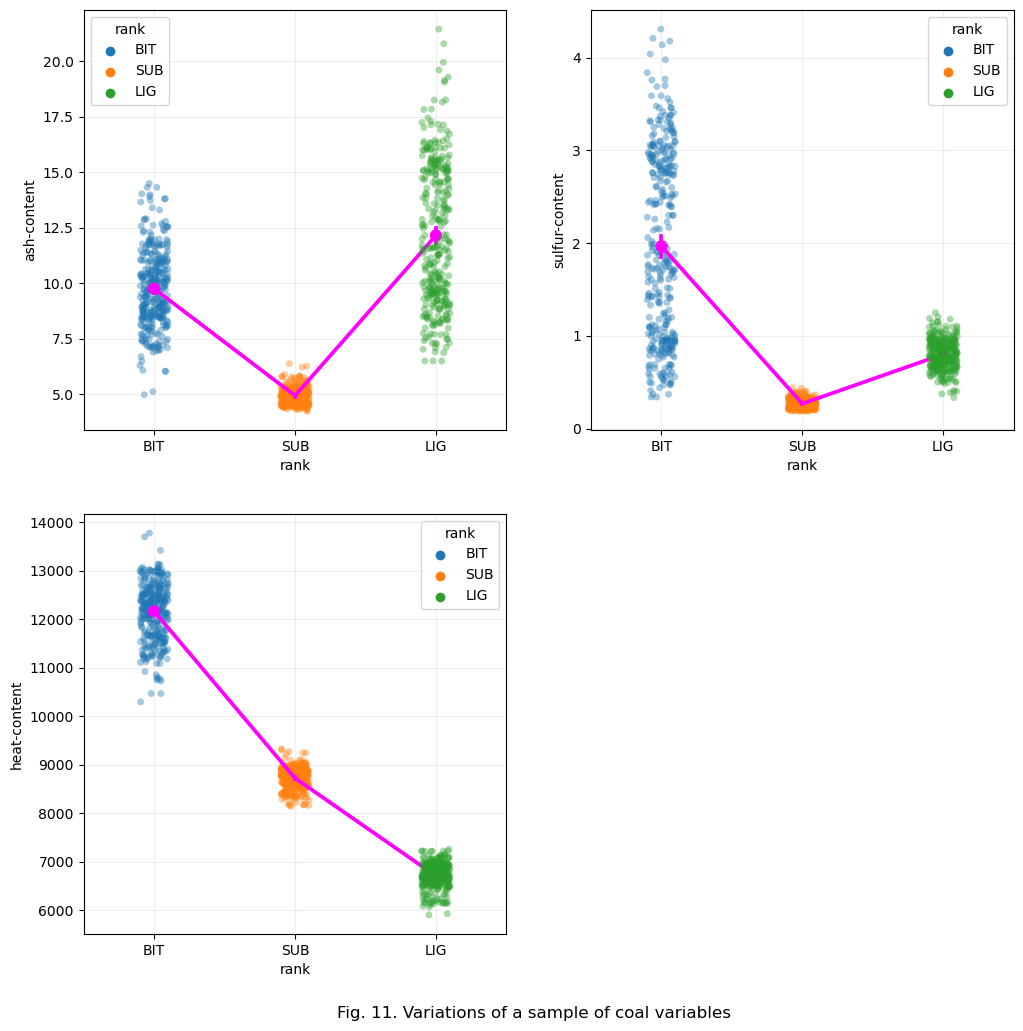

In [66]:
sample_data = coal_EDA_bal.sample(n=1000, random_state=42)
cat_order = ['BIT', 'SUB', 'LIG']

fig, ax = plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
sns.stripplot(x='rank', y='ash-content', data=sample_data, hue='rank', order=cat_order, hue_order=cat_order, marker='o', alpha=0.4)
sns.pointplot(x='rank', y='ash-content', data=sample_data, color='Magenta', order=cat_order, hue_order=cat_order)
plt.grid(alpha=0.2)

plt.subplot(2,2,2)
sns.stripplot(x='rank', y='sulfur-content', data=sample_data, hue='rank', order=cat_order, hue_order=cat_order, marker='o', alpha=0.4)
sns.pointplot(x='rank', y='sulfur-content', data=sample_data, color='Magenta', order=cat_order, hue_order=cat_order)
plt.grid(alpha=0.2)

plt.subplot(2,2,3)
sns.stripplot(x='rank', y='heat-content', data=sample_data, hue='rank', order=cat_order, hue_order=cat_order, marker='o', alpha=0.4)
sns.pointplot(x='rank', y='heat-content', data=sample_data, color='Magenta', order=cat_order, hue_order=cat_order)
plt.grid(alpha=0.2)

plt.subplots_adjust(hspace=0.2)


ax[0,0].get_children()[0].set_zorder(1)
ax[0,0].get_children()[1].set_zorder(2)

ax[0,1].get_children()[0].set_zorder(1)
ax[0,1].get_children()[1].set_zorder(2)

ax[1,0].get_children()[0].set_zorder(1)
ax[1,0].get_children()[1].set_zorder(2)


fig.delaxes(ax[1, 1])
plt.suptitle('Fig. 11. Variations of a sample of coal variables', y=0.05)
plt.show()

## **Detecting Multicollinearity**

Variance Inflation Factor $(VIF) = \large \frac{1}{1-R^2}$

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

coal_EDA_bal_copy = coal_EDA_bal.copy()

# Creating dummies for 'rank'
coal_EDA_bal_copy['rank'] = coal_EDA_bal_copy['rank'].map({'BIT': 0, 'SUB': 1, 'LIG': 2})

# Independent variables
X = coal_EDA_bal_copy[['ash-content', 'sulfur-content', 'heat-content']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

# Calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,ash-content,4.346826
1,sulfur-content,2.988210
2,heat-content,5.439859


'ash-content' is moderately correlated but 'heat-content' is highly correlated with one or more features in the data. We could remove highly correlated variables, but it may affect the predictive power of models.

## **Summarize and Plan the Transformation Pipeline**

**While cleaning data, we**
- Imputed 'NaN' Values Using `StratifiedStatisticalImputer`.
- Removed outliers using `MultivariateStratifedOutlierRemover`.
- Removed rare category (Anthracite).
- Using SMOTE, handled class imbalance in the data.

**During Exploratory Data Analysis we found**
- Average prices for coal ranks were in the following order ['BIT' > 'ANT' > 'SUB' > 'LIG']. Although it is important to note Anthracite was a rare category in the data.
- Coal production in the United States decreased by a factor of 1.95 from 2001 to 2021.
- Coals can be distinguished with their heat content. Higher grade coals (high heat-content) leave less ash.
- All variables, 'ash-content', 'sulfur-content' and 'heat-content' are statistically good predictors of coal rank.
- Heat-content is highly correlated with one or more variables in the data.

**Based on the above points we will build a Transformation pipeline that incorporates the following steps.**

1. Remove Anthracite observations from the data. (Transformer Not available!)
2. Impute 'Nan' values using `StratifiedStatiscalImputer`.
3. Remove outliers using `MultivariateStratifiedOutlierRemover`.
4. Oversample using `SMOTE`.
5. Encode labels (optional)
6. Standardize the data using Z-score.

In [68]:
# Additional transformer required for pipeline

class AnthraciteRemover(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        self.df = pd.concat([self.X_, self.y_], axis=1)
        return self

    def transform(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        df = pd.concat([X, self.y_], axis=1)
        df = df[df['rank'] != 'ANT'].reset_index(drop=True)
        data = df.drop('rank', axis=1)
        labels = df['rank']
        return data, labels

In [69]:
# Additional transformer required for pipeline

class ApplySMOTE(BaseEstimator, TransformerMixin):

    def __init__(self, random_state=None, split=False):
        self.random_state=random_state
        self.split = split

    def fit(self, X, y):
        self.y_ = y
        return self
    
    def transform(self, X):
        check_is_fitted(self, ['y_'])
        smote = SMOTE(random_state=self.random_state)
        X, y = smote.fit_resample(X, self.y_)
        return X, y
        

In [70]:
# Functions in the current and next cell to be used in `FunctionTransformer`.

def combine_inputs(tup: tuple) -> pd.DataFrame:
    result = pd.concat([tup[0], pd.DataFrame(tup[1])], axis=1)
    return result

In [71]:
def label_encoder(data: pd.DataFrame) -> pd.DataFrame:
    data[data.columns[-1]] = data[data.columns[-1]].map({'BIT': 0, 'SUB': 1, 'LIG': 2})
    return data

In [72]:
coal_inputs = X_train[['ash-content', 'sulfur-content', 'heat-content']]
coal_labels = y_train.to_frame()

## **Transformation Pipeline**

Why do we need a `CustomPipeline` class?<br>


It turns out that the first four steps in the Transformation Pipeline use Custom Transformers ( stateful ) that we created earlier as shown in the steps above. The standard `Pipeline` class in Scikit-Learn is incompatible with the requirements of data flow in the pipeline. Therefore it is necessary to create a `CustomPipeline` class. `CustomPipeline` inherits from Scikit-Learn's `Pipeline` class and modifies its `fit_transform` method using a decorator.

In [73]:
from sklearn.pipeline import Pipeline

class CustomPipeline(Pipeline):

    def modified_fit_transform(fit_transform):
        def wrapper(self, X, y=None, **fit_params):
            steps = super().get_params()['steps']
            for i in range(len(steps)):
                X, y = steps[i][1].fit_transform(X, y)
            return X, y
        return wrapper


    @modified_fit_transform        
    def fit_transform(self, X, y=None, **fit_params):
        return super().fit_transform(X, y, **fit_params)

In [74]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# This Pipeline handles preprocessing of data using stateful Transformers.
stateful_pipeline = CustomPipeline([
    ('anth_remover', AnthraciteRemover()),
    ('ssimputer', StratifiedStatisticalImputer(strategy='median', random_state=42, split=True)),
    ('out_remover', MultivariateStratifiedOutlierRemover(strategy=1.5, random_state=42, split=True)),
    ('smote', ApplySMOTE(random_state=42, split=True)),
])

# This pipeline combines items of tuple outputted by the previous one and 
# performs 'label encoding' on the last column.
comb_pipeline = Pipeline([
    ('comb', FunctionTransformer(combine_inputs)),
    # ('label_enc', FunctionTransformer(label_encoder)), # Label encoding is disabled
])

# This pipeline handles preprocessing of data using stateless Transformers.
stateless_pipeline = ColumnTransformer(transformers=[
        ('scaler', StandardScaler(), ['ash-content', 'sulfur-content', 'heat-content']),   
    ],
    remainder='passthrough'
)

# This is a nested pipeline that contains the above pipelines.
preprocessor = Pipeline([
    ('ful_pipeline', stateful_pipeline),
    ('com_pipeline', comb_pipeline),
    ('les_pipeline', stateless_pipeline),
])

In [75]:
coal_prepro = preprocessor.fit_transform(coal_inputs, coal_labels)
coal_prepro

array([[0.6121277543665019, 1.052060986400145, 1.4721843584988925, 'BIT'],
       [-0.27087131162308686, 0.2916346494273871, 1.3399915767691404,
        'BIT'],
       [0.12477515414672892, 0.11782291526218536, 1.4730627158525786,
        'BIT'],
       ...,
       [-1.1491947961873556, -0.8337400348892778, -0.24061248118892714,
        'SUB'],
       [-1.2122014387168936, -0.8723341396540892, -0.16902635686351314,
        'SUB'],
       [-1.0844005706541335, -0.8304688252603243, -0.059386785535871234,
        'SUB']], dtype=object)

## **Machine Learning**

We shall try the following classification algorithms:
1. Softmax Regression
2. Decision Tree classifier
3. Random Forest classifier
4. Feed Forward Network (FFN)

In [76]:
# Performance measure

def performance(scores: dict) -> None:

    print("\033[1mPERFORMANCE REPORT\033[0m\n------------------")

    print("\033[1mTRAIN SET\033[0m\n---------")
    print(f"\033[1m\033[92mAccuracy scores\033[00m\033[0m: {scores['train_accuracy']}")
    print(f"Mean: {np.mean(scores['train_accuracy'])}")
    print(f"SD: {np.std(scores['train_accuracy'])}")

    print(f"\033[1m\033[92mPrecision scores\033[00m\033[0m: {scores['train_precision_macro']}")
    print(f"Mean: {np.mean(scores['train_precision_macro'])}")
    print(f"SD: {np.std(scores['train_precision_macro'])}")

    print(f"\033[1m\033[92mRecall scores\033[00m\033[0m: {scores['train_recall_macro']}")
    print(f"Mean: {np.mean(scores['train_recall_macro'])}")
    print(f"SD: {np.std(scores['train_recall_macro'])}")

    print(f"\033[1m\033[92mF1 scores\033[00m\033[0m: {scores['train_f1_macro']}")
    print(f"Mean: {np.mean(scores['train_f1_macro'])}")
    print(f"SD: {np.std(scores['train_f1_macro'])}")

    print(' ')
    print("\033[1mTEST SET\033[0m\n--------")
    
    print(f"\033[1m\033[92mAccuracy scores\033[00m\033[0m: {scores['test_accuracy']}")
    print(f"Mean: {np.mean(scores['test_accuracy'])}")
    print(f"SD: {np.std(scores['test_accuracy'])}")

    print(f"\033[1m\033[92mPrecision scores\033[00m\033[0m: {scores['test_precision_macro']}")
    print(f"Mean: {np.mean(scores['test_precision_macro'])}")
    print(f"SD: {np.std(scores['test_precision_macro'])}")

    print(f"\033[1m\033[92mRecall scores\033[00m\033[0m: {scores['test_recall_macro']}")
    print(f"Mean: {np.mean(scores['test_recall_macro'])}")
    print(f"SD: {np.std(scores['test_recall_macro'])}")

    print(f"\033[1m\033[92mF1 scores\033[00m\033[0m: {scores['test_f1_macro']}")
    print(f"Mean: {np.mean(scores['test_f1_macro'])}")
    print(f"SD: {np.std(scores['test_f1_macro'])}")

In [77]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [92]:
ml_inputs = coal_prepro[:, 0:-1].astype(float)
ml_labels = coal_prepro[:, -1]

#### 1. Softmax Regression

In [93]:
# Softmax Regression
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs")
softmax_reg_scores = cross_validate(
    estimator=softmax_reg, 
    X=ml_inputs, 
    y=ml_labels, 
    scoring=scoring,
    cv=10,
    return_train_score=True,
)
performance(softmax_reg_scores)

PERFORMANCE REPORT
------------------
TRAIN SET
---------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065265514923
SD: 3.283714775455775e-05
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998066420686023
SD: 3.280300528211566e-05
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065267794773
SD: 3.283641808422002e-05
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065266763712
SD: 3.283660469004669e-05
 
TEST SET
--------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065302019018
SD: 0.00029552327470951074
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998069082643214
SD: 0.00029483203544105257
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065486713393
SD: 0.0002954614481821285
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 0.9998065415621158


#### 2. Decision Tree Classifier

In [94]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf_scores = cross_validate(
    estimator=tree_clf,
    X=ml_inputs,
    y=ml_labels,
    scoring=scoring,
    cv=10,
    return_train_score=True,
)
performance(tree_clf_scores)

PERFORMANCE REPORT
------------------
TRAIN SET
---------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
 
TEST SET
--------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0


#### 3. Random Forest Classifier

In [95]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf_scores = cross_validate(
    estimator=forest_clf,
    X=ml_inputs,
    y=ml_labels,
    scoring=scoring,
    cv=10,
    return_train_score=True,
)
performance(forest_clf_scores)

PERFORMANCE REPORT
------------------
TRAIN SET
---------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
 
TEST SET
--------
Accuracy scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Precision scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
Recall scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0
F1 scores: [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00]
Mean: 1.0
SD: 0.0


The cross validation results not only show that the train and test(validation) scores are really close to each other, but also 'phenomenal'. This is an indication that the models are not overfitting and 'Hyperparameter Tuning' is not necessary.

Decision tree classifer and Random forest classifier performed better (in CV) than softmax regression. Let's inspect the confusion matrix of Softmax regression.

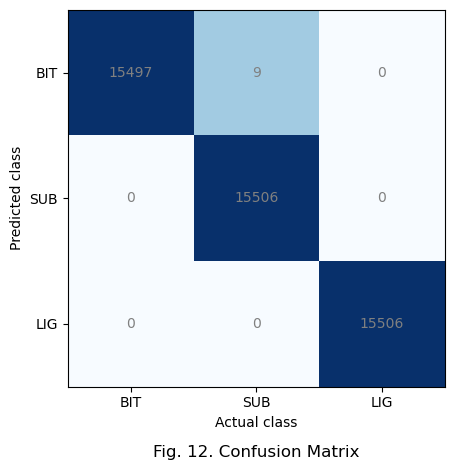

In [96]:
from sklearn.metrics import confusion_matrix

# Fit the previously created instance (without CV)
softmax_reg.fit(ml_inputs, ml_labels)
softmax_reg_pred = softmax_reg.predict(ml_inputs) # predict on entire training set explicitly.

matrix = confusion_matrix(ml_labels, softmax_reg_pred, labels=['BIT', 'SUB', 'LIG'])

plt.imshow(matrix, cmap='Blues',vmin=0, vmax = 25)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.annotate(str(matrix[i][j]), xy=(j, i), ha='center', va='center', color='gray')
plt.xticks([0, 1, 2], ['BIT', 'SUB', 'LIG'])
plt.yticks([0, 1, 2], ['BIT', 'SUB', 'LIG'])
plt.suptitle('Fig. 12. Confusion Matrix', y=0)
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.tight_layout()
plt.show()

The horizontal entries (X-axis) represent the actual classes (labels), and the vertical entries represent the predicted classes. Looking at the confusion matrix, the `softmax_reg` model did 9 misclassifications. It misclassified 9 'SUB' (Subbituminous) samples as 'BIT' (Bituminous).

#### 4. Feed Forward Network

In [97]:
# Import PyTorch and related modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [98]:
# Convert data and labels into PyTorch Tensors
dataT = torch.tensor(ml_inputs).float()
encoded_labels = label_encoder(pd.DataFrame(ml_labels, columns=['rank'])).to_numpy()
labelsT = torch.tensor(encoded_labels).flatten().long()

In [99]:
dataT, labelsT

(tensor([[ 0.6121,  1.0521,  1.4722],
         [-0.2709,  0.2916,  1.3400],
         [ 0.1248,  0.1178,  1.4731],
         ...,
         [-1.1492, -0.8337, -0.2406],
         [-1.2122, -0.8723, -0.1690],
         [-1.0844, -0.8305, -0.0594]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]))

In [101]:
# Create Validation set
from sklearn.model_selection import train_test_split
X_Train, X_Val, y_Train, y_Val = train_test_split(dataT, labelsT, test_size=0.15, random_state=42)
print('Train Set info: input {0}, targets {1}\nValidation Set info: input {2}, targets {3}'.format(X_Train.shape, y_Train.shape, X_Val.shape, y_Val.shape))

Train Set info: input torch.Size([39540, 3]), targets torch.Size([39540])
Validation Set info: input torch.Size([6978, 3]), targets torch.Size([6978])


In [102]:
# Convert to PyTorch Datasets
train_data = TensorDataset(X_Train, y_Train)
test_data = TensorDataset(X_Val, y_Val)

# Translate to DataLoaders
batchsize = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [103]:
# ARCHITECTURE
class FeedForwardNetwork(nn.Module):
    """
    A subclass of nn.Module to create a Feed Forward Network architecture.

    Parameters:
    -----------
        n_hid (int): number of units in the hidden layer.
  
    """
    def __init__(self, n_hid=1) -> None:
        super().__init__()
        self.n_hid = n_hid

        # Input layer 
        self.input = nn.Linear(3, n_hid) 

        # Hidden layer
        self.hidden = nn.Linear(n_hid, n_hid)

        # Output layer
        self.output = nn.Linear(n_hid, 3)

    # Forward pass
    def forward(self, X):
        """
        Implements forward propagation.

        Parameters:
        -----------
            X (torch.utils.data.DataLoader): The Data for forward pass

        Returns:
        --------
            X (torch.utils.data.DataLoader): The transformed data after forward propagation through
            input, hidden and output layer's linear function for feeding into log-softmax 
            activation function. 
        """

        # through input layer and its activation function (relu).
        X = F.relu(self.input(X))

        # through hidden layer and its activation function (relu).
        X = F.relu(self.hidden(X))

        # through output layer 
        X = self.output(X)

        # return raw output
        return X

In [104]:
# MODEL BUILDING

def createFFN(hid_units: int, learning_rate: float):
    """
    A Function to create Feed Forward Network.

    Arguments:
    ----------
        hid_units: (int) Number of units in the hidden layer.

        learning_rate: (float) Set learning rate for the model to optimize weights.

    Returns:
    --------
        net, lossfun, optimizer (tuple): An instance of FeedForwardNetwork class, a loss function
        for gradient descent and an Adam optimizer with specified learning rate. 
    """
    # FFN instance with n hidden unit in the hidden layer.
    net = FeedForwardNetwork(n_hid=hid_units)

    # Loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    return net, lossfun, optimizer

In [105]:
# MODEL TRAINING

def trainFFN(net, lossfun, optimizer, epochs: int):
    """
    A function to train a FeedForwardNetwork

    Arguments:
    ----------
        net (torch.nn.Module): An instance of FeedForwardNetwork.

        lossfun (torch.nn.modules.loss._Loss): A Loss function for gradient descent.

        optimizer (torch.optim.Optimizer): The optimizer to use for training.

        epochs (int): Number of iterations for training.

    Returns:
    -------
        net, train_acc, test_acc (tuple): The trained FFN, its train and test accuracies.
    """
    numepochs = epochs

    # Initialize Accuraies
    train_acc = []
    test_acc = []

    for epoch in range(numepochs):

        # Initialize batch Accuracies
        batch_acc = []

        # Loop through the batches
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)

            # Loss function
            loss = lossfun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Accuracy
            # batch_acc.append(accuracy_score(y.float().detach().numpy(), torch.argmax(yHat, axis=1).float().detach().numpy()))
            batch_acc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        # Average batch Accuracy
        train_acc.append(np.mean(batch_acc))

        # Fetch X and y values from the testloader
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X) 

        # Test Accuracy
        test_acc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

    return net, train_acc, test_acc

In [108]:
# Create a model
ffn, lossf, optim = createFFN(hid_units=1, learning_rate=0.001)

# Train the model
ffn, train_acc, test_acc = trainFFN(net=ffn, lossfun=lossf, optimizer=optim, epochs=30)

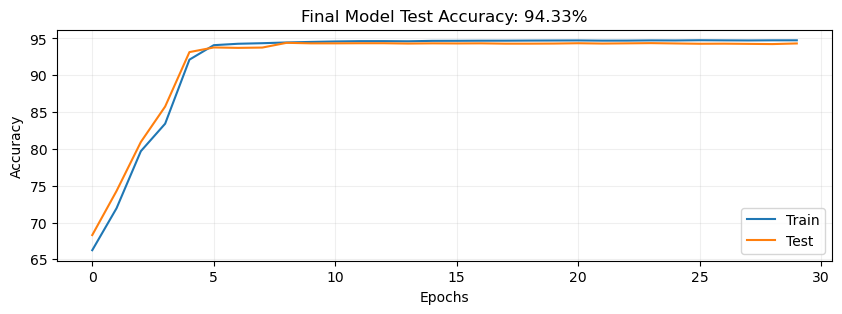

In [109]:
# Plot of performance
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(train_acc, label='Train')
ax.plot(test_acc, label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title(f"Final Model Test Accuracy: {test_acc[-1]:.2f}%")
ax.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

Pretty decent model! Accuracy above 90% with just 1 lonely unit in the hidden layer. Let's tune hyperparameters particularly learning rate and number of units in the hidden layer.

## **Hyperparameter Tuning**

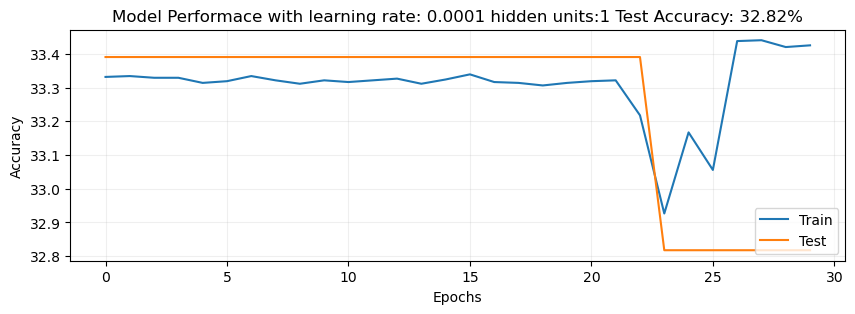

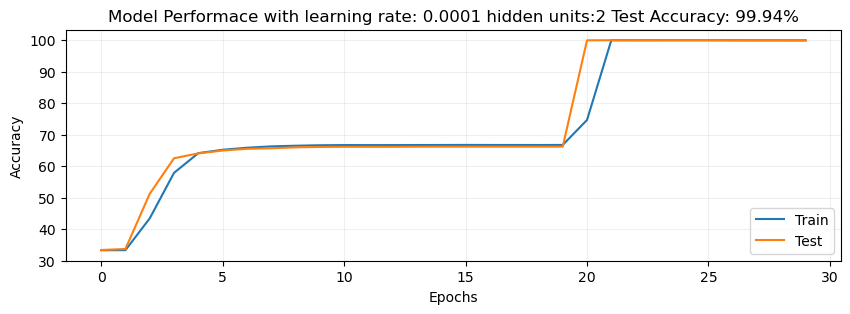

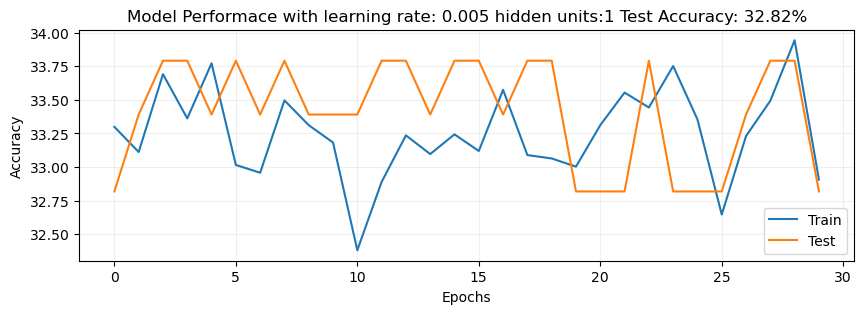

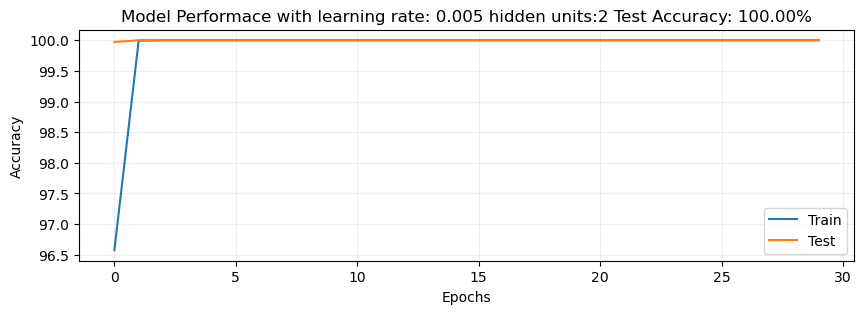

In [112]:
learning_rates = [0.0001, 0.005]
hid_units = [1, 2]

lr_dict = {}
for lr in learning_rates:
    hu_dict = {}
    for hu in hid_units:
        # Create FFN
        ffn, lossf, optim = createFFN(hid_units=hu, learning_rate=lr)
        # Train FFN
        ffn, train_acc, test_acc = trainFFN(net=ffn, lossfun=lossf, optimizer=optim, epochs=30)
        # Store outputs
        hu_dict[str(hu)] = ffn
        # Plot accuracy
        fig, ax = plt.subplots(figsize=(10,3))
        ax.plot(train_acc, label='Train')
        ax.plot(test_acc, label='Test')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_title(f"Model Performace with learning rate: {lr} hidden units:{hu} Test Accuracy: {test_acc[-1]:.2f}%")
        ax.legend(loc='lower right')
        plt.grid(alpha=0.2)
        plt.show()

    # Store outputs
    lr_dict[str(lr)] = hu_dict

In the first experiement the model performed poorly. Since the accuracy is around 33%, we can say that it was purely guessing one of the three categories. This can be due to either the model not being complex enough or the learning rate being too small to reach global minima in 30 epochs. In the second experiment with increased model complexity,the model performed exceptionally well depsite having the same learning rate! This suggested the losses may have reached a global minima. In the third experiment with increased learning rate and decreased complexity, the model couldn't learn. Finally with both hyperparameters increased, we get a very good Test accuracy. It is important to note that each experiment was conducted only once and the results are not averaged. Perhaps if the experiments were conducted multiple times, the results may not be consistent. Eitherway a learning rate of 0.005 and a model complexity of 2 units in the hidden layer seems logically and instinctively secure. 

## **Saving Best Models**

In [113]:
import joblib

In [116]:
# Fit and Save the Decision Tree (Since we didn't earlier)
tree_clf.fit(ml_inputs, ml_labels)
joblib.dump(tree_clf, 'models/tree_clf.pkl')

['models/tree_clf.pkl']

In [117]:
# Likewise Random Forest
forest_clf.fit(ml_inputs, ml_labels)
joblib.dump(forest_clf, 'models/forest_clf.pkl')

['models/forest_clf.pkl']

In [118]:
# Save the FNN with learning rate=0.005 and No. of units in the hidden layer=2
trained_ffn = lr_dict['0.005']['2']
torch.save(trained_ffn.state_dict(), 'models/FFN.pt')

## **Predicting on the Test Set**

In [119]:
# Load the saved models
tree_clf = joblib.load('models/tree_clf.pkl')
forest_clf = joblib.load('models/forest_clf.pkl')

In [120]:
FFN = createFFN(hid_units=2, learning_rate=0.005)[0]
FFN.load_state_dict(torch.load('models/FFN.pt'))

<All keys matched successfully>

In [125]:
# Define test inputs and labels for the transformation pipeline.
coal_test_inputs = X_test[['ash-content', 'sulfur-content', 'heat-content']]
coal_test_labels = y_test.to_frame()

In [129]:
# Preprocess the test data using the Transformation pipeline. Please note that we are doing 
# `fit_transform` instead of `transform`, since some of the preprocessing transformers are not inductive.
coal_test_prepro = preprocessor.fit_transform(coal_test_inputs, coal_test_labels)
coal_test_prepro

array([[0.4832324568524896, 0.3338602974089185, 1.344101297156507, 'BIT'],
       [0.7034635361492078, 0.2908152970136363, 1.2791742140751055,
        'BIT'],
       [0.2125870341023061, 0.08635154513604583, 1.489309841075047,
        'BIT'],
       ...,
       [-1.044998254823834, -0.8138442735839, -0.1462652085708778, 'SUB'],
       [-1.1678018014947262, -0.8187756803144975, -0.1338672359599917,
        'SUB'],
       [-1.0251571874542573, -0.8189543757098148, -0.12026764423348192,
        'SUB']], dtype=object)

In [133]:
# Define test inputs and labels for the model
ml_test_inputs = coal_test_prepro[:, 0:-1].astype(float)
ml_test_labels = coal_test_prepro[:, -1]

In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [135]:
def final_performance(test_pred, test_labels):
    print("\033[1mPERFORMANCE REPORT\033[0m\n------------------")
    print(f"Accuracy score: {accuracy_score(test_labels, test_pred)}")
    print(f"Precision score: {precision_score(test_labels, test_pred, average='macro')}")
    print(f"Recall score: {recall_score(test_labels, test_pred, average='macro')}")
    print(f"F1 score: {f1_score(test_labels, test_pred, average='macro')}")


In [136]:
# Predict using Decision Tree
tree_clf_test_pred = tree_clf.predict(ml_test_inputs)
final_performance(ml_test_labels, tree_clf_test_pred)

PERFORMANCE REPORT
------------------
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [137]:
# Predict using Random Forest
forest_clf_test_pred = forest_clf.predict(ml_test_inputs)
final_performance(ml_test_labels, forest_clf_test_pred)

PERFORMANCE REPORT
------------------
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [138]:
# Predict using FFN

# Convert data and labels into PyTorch Tensors
dataT = torch.tensor(ml_test_inputs).float()
encoded_labels = label_encoder(pd.DataFrame(ml_test_labels, columns=['rank'])).to_numpy()
labelsT = torch.tensor(encoded_labels).flatten().long()

# Convert to PyTorch Datasets
test_data = TensorDataset(dataT, labelsT)

# Translate to DataLoaders
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

yHat = FFN(test_loader.dataset.tensors[0])
ffn_test_pred = torch.argmax(yHat, axis=1).detach().numpy()
final_performance(encoded_labels, ffn_test_pred)

PERFORMANCE REPORT
------------------
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


The Models performed well on Test data as well. As we have seen the models didn't require hyperparameter tuning, even a very simple FFN model was able to correctly classify 100% of the observations. This could be because the data is easily classifiable. 

***We have reached the end of this notebook, I took great joy in working on this machine learning project. Given the size of this notebook, experiments and implementation of new classes and other contents it is likely that I have made mistakes or made use of methodologies that would endup presenting errors. Feel free to discuss any issues related to this notebook.***

***Thanks for patiently reading!***

------------------------------